In [1]:
import random
import pandas as pd
import time
import cdd
import enum
from math import sqrt, atan, floor, ceil, pi
import numpy as np
import sys

# libraries for LP 
from pulp import LpMinimize, LpProblem, LpStatus, LpVariable, LpMaximize, PULP_CBC_CMD
import gurobipy as gp

%matplotlib inline
from matplotlib import pyplot as plt



import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession




conf=pyspark.SparkConf().setMaster("local[20]").setAppName("Skyline Algos")
#conf=pyspark.SparkConf().setMaster('spark://master:7077').setSparkHome('/usr/local/spark').setAppName("Skyline Algos")

#conf.set("spark.executor.instances", "1")
#conf.set("spark.executor.memory", "6g")
#conf.set("spark.worker.memory", "18g")
#conf.set("spark.driver.bindAddress", "10.75.4.81")
#conf.set("spark.driver.port", "8619")
#conf.set("spark.driver.host", "10.75.4.81")
conf.set("spark.driver.memory", "2g")
#conf.set("spark.executor.memory", "4g")

spark = SparkSession.builder.config(conf=conf).getOrCreate()




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/06 12:08:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:

#global value for the coefficient of the Constraints
#case 2 dimension
# -x + y <= 0
# 0 <= x <= 1
# 0 <= y <= 1
A = np.array([[-1, 1],
                 [-1, 0],
                 [1, 0],
                 [0, -1],
                 [0, 1]])
b = np.array([[0],[0],[1],[0],[1]])
# x + y = 1
C = np.array([[1, 1]])
d = np.array([[1]])

#case 4 dimensions
# -x + y <= 0
# 0 <= x <= 1
# 0 <= y <= 1
# 0 <= z <= 1
# 0 <= u <= 1
E = np.array([[-1, 1, 0, 0],
                 [-1, 0, 0, 0],
                 [1, 0, 0, 0],
                 [0, -1, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, -1, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, -1],
                 [0, 0, 0, 1]])
f = np.array([[0],[0],[1],[0],[1],[0],[1],[0],[1]])
# x + y +z + u= 1
G = np.array([[1, 1, 1, 1]])
h = np.array([[1]])

#case 6 dimensions
# -x + y <= 0
# 0 <= x <= 1
# 0 <= y <= 1
# 0 <= z <= 1
# 0 <= u <= 1
#...
I = np.array([[-1, 1, 0, 0, 0, 0],
                 [-1, 0, 0, 0,0,0],
                 [1, 0, 0, 0,0,0],
                 [0, -1, 0, 0,0,0],
                 [0, 1, 0, 0,0,0],
                 [0, 0, -1, 0,0,0],
                 [0, 0, 1, 0,0,0],
                 [0, 0, 0, -1,0,0],
                 [0, 0, 0, 1,0,0],
                 [0, 0, 0, 0,-1,0],
                 [0, 0, 0, 0,1,0],
                 [0, 0, 0, 0,0,-1],
                 [0, 0, 0, 0,0,1]])
l = np.array([[0],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1]])
# x + y +z + u + ..= 1
M = np.array([[1, 1, 1, 1, 1, 1]])
n = np.array([[1]])
#case 7 dimensions
# -x + y <= 0
# 0 <= x <= 1
# 0 <= y <= 1
# 0 <= z <= 1
# 0 <= u <= 1
#...
O = np.array([[-1, 1, 0, 0, 0, 0, 0],
                 [-1,0, 0, 0, 0, 0, 0],
                 [1, 0, 0, 0, 0, 0, 0],
                 [0,-1, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0],
                 [0, 0,-1, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0,-1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0,-1, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0,-1, 0],
                 [0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, -1],
                 [0, 0, 0, 0, 0, 0, 1],])
p_ = np.array([[0],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1]])
# x + y +z + u + ..= 1
Q = np.array([[1, 1, 1, 1, 1, 1, 1]])
r = np.array([[1]])

In [3]:
#function to check if a tuple dominates another tuple
def dominates(a, b):
    hasStrict = False
    
    for i in range(len(a)):
        if a[i] > b[i]:
            return False
        elif a[i] < b[i]:
            hasStrict = True
    return hasStrict

#function to compute the value of one side of the inequality in VE version
def computeInequality(tupl, vertices, p):
    res = []
    for i in range(len(vertices)):
        value = 0
        for j in range(len(tupl)):
            value += vertices[i][j]*(tupl[j]**p)
        res.append(value)   
    #print(res)
    return res

#function that computes the objective function of the LP based on the value of the two tuples that we are comparing
def objective_function(i, j, p):
    obj_func_w = []
    for k in range(len(i)):
        obj_func_w.append(i[k]**p - j[k]**p)
    
    return obj_func_w

#function that computes the coordinates of the centroid using the vertex of the polyhedron
def compute_centroid(vertices):
    sum_axis = []
    centroid = []
    for i in range(len(vertices[0])):
        sum_axis.append(0)
        centroid.append(0)
    for i in range(len(vertices)):
        for j in range(len(vertices[i])):
            sum_axis[j] += vertices[i][j]
    for i in range(len(sum_axis)):
        centroid[i] = sum_axis[i] / len(vertices)
    
    return centroid

#sort function based on weights (e.g. centroid coordinates)
def sort_function(data, weight):
    value = 0
    for i in range(len(data)):
        value += data[i]*weight[i]
    return value

#function to compute the vertices from a set of equation
def computeVertices(A,b,C,d):
    m_ineq = np.hstack( (b, -A) )

    mat = cdd.Matrix(m_ineq, number_type='float') 
    mat.rep_type = cdd.RepType.INEQUALITY

    m_eq = np.hstack( (d, -C) )
    mat.extend(m_eq, linear=True)
    #print(mat.__getitem__(0), mat.__getitem__(1))
    # print(mat.lin_set)

    poly = cdd.Polyhedron(mat)
    ext = poly.get_generators()
    #print(ext)
    vertices = []
    for i in range(len(ext)):
        w2 = []
        for j in range(len(ext[i][1:])):
            w2.append(ext[i][j+1])
        vertices.append(w2)
    print('Vertices: ' + str(vertices))
    
    return vertices

#function that computes the left side of the equations in the po algorithm
def computeLeftSide(variables,po,i,p):
    value= 0 
    for j in range(len(variables)):
        value += variables[j]*(po[j][i]**p)
    return value

def getVariables(numDim):
    variables = []
    for i in range(numDim):
        variables.append(LpVariable(name= "x" + str(i), lowBound= 0,upBound=1))
    
    return variables

def getVariables_primal(numDim):
    variables = []
    variables.append(LpVariable(name= "phi"))
    for i in range(numDim):
        variables.append(LpVariable(name= "x" + str(i), lowBound= 0,upBound=1))

    return variables

#function that creates a gurobipy model for the dual computation of po
def getModel_dual(num):
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.start()
        m=gp.Model(env=env)
    m.Params.LogToConsole = 0
    variables = []
    for i in range(num):
        x= m.addVar(lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="x" + str(i))
        variables.append(x)
    
    return m,variables

#function that creates a gurobipy model for the computation of nd
def getModel_nd(num):
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.start()
        m=gp.Model(env=env)
    m.Params.LogToConsole = 0
    variables = []
    var_names = []
    for i in range(num):
        x= m.addVar(lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="x" + str(i))
        variables.append(x)
        var_names.append("x"+str(i))
    
    return m,variables,var_names

#function that creates a gurobipy model for the primal computation of po
def getModel_primal(numDim):
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.start()
        m=gp.Model(env=env)
    m.Params.LogToConsole = 0
    variables = []
    var_names = []
    phi= m.addVar(vtype=gp.GRB.CONTINUOUS, name="phi")
    variables.append(phi)
    var_names.append("phi")
    for i in range(numDim):
        x= m.addVar(lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="w" + str(i))
        variables.append(x)
        var_names.append("w"+str(i))
    
    return m,variables,var_names

#function that compute the volume 
def volume(p):
    volume = 1
    for i in range(len(p)):
        volume *= p[i]
    return volume




In [4]:
# function that find the skyline using BNL
def find_skyline_bnl(data):
    #Finds the skyline using a block-nested loop.
    if not isinstance(data,list):
        data = list(data)
    skyline = []
    c = 0
    for i in data:
        is_dominated = False
        for j in skyline:
            c += 1
            if dominates(j,i):
                is_dominated = True
                break
        if is_dominated:
            continue
        # removing dominated points from the window
        to_drop = []
        for k in skyline:
            c += 1
            if dominates(i, k):
                to_drop.append(k)

        for drop in to_drop:
            skyline.remove(drop)

        skyline.append(i)

    print('comparisons:'+str(c))
        
    return skyline

def find_skyline_sfs(data, weights):

    if not isinstance(data,list):
        data = list(data)

    #sort the dataset using a sort function
    data.sort(key = lambda x: sort_function(x, weights))

    skyline = []
    #c = 0
    # Loop through the rest of the rows
    for i in data:
        is_dominated = False

        for j in skyline:
            #c+=1
            if dominates(j,i):
                is_dominated = True
                break

        if is_dominated:
            continue

        skyline.append(i)

    #print('comparisons:'+str(c))
    return skyline

def find_skyline_sfs2(data):

    if not isinstance(data,list):
        data = list(data)

    #sort the dataset using a sort function
    data.sort()

    skyline = []
    c = 0
    # Loop through the rest of the rows
    for i in data:
        is_dominated = False

        for j in skyline:
            c+=1
            if dominates(j,i):
                is_dominated = True
                break

        if is_dominated:
            continue

        skyline.append(i)

    print('comparisons:'+str(c))
    return skyline



#function that finds the skyline using SaLSa
def find_skyline_SaLSa(data):
    if not isinstance(data,list):
        data = list(data)
    c = 0
    if len(data)== 0:
        return []
    data.sort(key= lambda x: (min(x), sum(x)))
    
    skyline = []
    
    p_stop = data[0]
    
    for p in data:
        is_dominated = False
        if (min(p) > max(p_stop)) or ((min(p) == max(p_stop)) and p != p_stop):
            break
      
        for i in skyline:
            c += 1
            if dominates(i, p):
                is_dominated = True
                break
        
        if not is_dominated:
            if max(p) < max(p_stop):
                p_stop = p
            
            skyline.append(p)
    print('comparisons: '+str(c))
    return skyline





In [5]:
def sfs_with_memory(data, memory, weights):
    if not isinstance(data,list):
        data = list(data)

    #sort the dataset using a sort function
    data_sorted = data.copy()

    data_sorted.sort(key=lambda x: sort_function(x, weights))

    skyline = []

    for i in data_sorted:
        is_dominated = False

        for m in memory:
            if dominates(m,i):
                is_dominated = True
                break
        if is_dominated:
            continue

        for j in skyline:
            if dominates(j,i):
                is_dominated = True
                break

        if is_dominated:
            continue

        skyline.append(i)

    return skyline

def salsa_with_memory(data, memory):
    if not isinstance(data,list):
        data = list(data)

    if len(data)== 0:
        return []
    data.sort(key= lambda x: (min(x), sum(x)))
    #sort the dataset using a sort function
        
    skyline = []
    
    p_stop = data[0]
    
    for p in data:
        is_dominated = False
        if (min(p) > max(p_stop)) or ((min(p) == max(p_stop)) and p != p_stop):
            break
      
        for m in memory:
            if dominates(m,p):
                is_dominated = True
                break
        if is_dominated:
            continue
        
        for i in skyline:
            if dominates(i, p):
                is_dominated = True
                break
        
        if not is_dominated:
            if max(p) < max(p_stop):
                p_stop = p
            
            skyline.append(p)
        
    return skyline

def sfs_multithread(datapoints, global_set, weights):
    nd = []
    
    datapoints = list(datapoints)
        
    datapoints.sort(key=lambda x: sort_function(x, weights))
    
    for ps in datapoints:
        # ps : potentially non dominated point
        for other in global_set:
            if ps == other:
                nd.append(ps)
                break
            dominated = False
            if dominates(other, ps):
                dominated = True
                break
            
#         for other in global_set:
#             # dominated other
#             dominated = False
#             # num of dimensions in which the points are equal
#             dimEqual = 0
#             for k in range(len(global_set[0])):
#                 if ps[k] < other[k] :
#                     dominated = True
#                     break
#                 elif other[k] == ps[k]:
#                     dimEqual = dimEqual + 1
#             if dominated == True:
#                 continue
#             # We suppose that the global_set is ordered. 
#             # Keeping in mind that the global_set is a superset of our datapoints, if we find our point in the global_set
#             # then all other points can not dominated this current point.
#             if dimEqual == len(global_set[0]):
#                 nd.append(ps)
#                 break
            
#             break
            
    return nd


def salsa_multithread(data, global_set):
    nd = []

    if not isinstance(data,list):
        data = list(data)

    if len(data)== 0:
        return []
    data.sort(key= lambda x: (min(x), sum(x)))

    p_stop = data[0]

    for p in data:
        # ps : potentially non dominated point
        if (min(p) > max(p_stop)) or ((min(p) == max(p_stop)) and p != p_stop):
            break
        for other in global_set:
            # dominated other
            dominated = False
            # num of dimensions in which the points are equal
            dimEqual = 0
            for k in range(len(global_set[0])):
                if p[k] < other[k] :
                    dominated = True
                    break
                elif other[k] == p[k]:
                    dimEqual = dimEqual + 1
            if dominated == True:
                continue

            if max(p) < max(p_stop):
                p_stop = p
            # We suppose that the global_set is ordered.
            # Keeping in mind that the global_set is a superset of our datapoints, if we find our point in the global_set
            # then all other points can not dominated this current point.
            if dimEqual == len(global_set[0]):
                nd.append(p)
                break

            break

    return nd

def sve1f_multithread(data, global_set, vertices, p):

    if not isinstance(data,list):
        data = list(data)

    if len(data) == 0:
        return []

    centroids =  compute_centroid(vertices)
    #print(centr)
    data.sort(key=lambda x: sort_function(x, centroids))
    nd = []
    for d in data:
        left_hand_side = computeInequality(d, vertices, p)
        is_dominated = True
        for other in global_set:
            # dominated other
            if other == d:
                nd.append(d)
                break
            if dominates(other, d):
                break
            right_hand_side = computeInequality(other, vertices, p)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t F-dominates s otherwise no
                is_dominated = True
                if left_hand_side[k] < right_hand_side[k]:
                    is_dominated = False
                    break
            if is_dominated:
                break

    return nd

def pond_primal_pulp_multithread(data, global_set, constraints, k_):
    if not isinstance(data,list):
        data = list(data)

    if len(data) == 0:
        return []

    delta = 2
    lastRound = False
    minimum = 0
    dimensions = len(data[0])

    while(not lastRound):

        if delta >= (len(global_set) - 1):
            lastRound = True
        data_reversed = data.copy()
        data_reversed.reverse()
        for t in data_reversed: #candidate F-dominated tuple
            model = LpProblem(sense=LpMaximize)
            #Prepare the LP model
            variables = getVariables_primal(dimensions)

            temp2 = 0
            for cons in constraints:
                i = 0
                for index in range(len(cons)):
                    temp2 += cons[index]*variables[index+1]
                model += (temp2 <= k_[i])
                i += 1

            minimum = min(delta, len(global_set)-1)
            if minimum == 0:
                break
            temp = 0
            for i in range(len(variables)-1):
                temp += variables[i+1]
            model += temp == 1

            po_temp = global_set.copy()
            po_temp.remove(t)

            for j in range(minimum): #compute the inequalities and add it to the LP model
                left_side = 0
                for i in range(dimensions):
                    left_side += variables[i+1] * (t[i]-po_temp[j][i])
                model += (left_side + variables[0] <= 0)
            model.setObjective(variables[0])

            model.solve(PULP_CBC_CMD(msg=False))

            if (model.objective.value() > 0):
                continue

            data.remove(t)
            global_set.remove(t)

            del model

        delta = delta * 2

    return data


def po_primal_pulp_non_inc_multi(po, global_set, constraints, k_):
    if not isinstance(po,list):
        po = list(po)

    if len(po) == 0:
        return []
    dimensions = len(po[0])
    po_reversed = po.copy()
    po_reversed.reverse()
    for t in po_reversed:
        model = LpProblem(sense=LpMaximize)
        #Prepare the LP model
        variables = getVariables_primal(dimensions)
        temp2 = 0
        for cons in constraints:
            i = 0
            for index in range(len(cons)):
                temp2 += cons[index]*variables[index+1]
            model += (temp2 <= k_[i])
            i += 1
        temp = 0
        for i in range(len(variables)-1):
            temp += variables[i+1]

        model += temp == 1
        po_temp = global_set.copy()
        po_temp.remove(t)
        for j in range(len(po_temp)): #compute the inequalities and add it to the LP model
            left_side = 0
            for i in range(dimensions):
                left_side += variables[i+1] * (t[i]-po_temp[j][i])
            model += (left_side + variables[0] <= 0)
        model.setObjective(variables[0])
        model.solve(PULP_CBC_CMD(msg=False))

        if (model.objective.value() > 0): # PO contains t iff the linear system is infeasible, otherwise is F-dominated by a convex combination of the other
#                 print("Removed "+ str(t))
            continue
            #po_reversed.remove(t)
        po.remove(t)
        del model

    return po

def sve1_with_memory(data, memory, vertices, p):
    #PHASE 1
    if not isinstance(data,list):
        data = list(data)

    nd = []
    #count = 0
    centr =  compute_centroid(vertices)
    #print(centr)
    data_sorted = data.copy()
    data_sorted.sort(key=lambda x: sort_function(x, centr))
    for s in data_sorted: #candidate F-dominated tuple
        is_dominated = False
        for m in memory:
            if dominates(m,s):
                is_dominated = True
                break
        if is_dominated:
            continue
        for t in nd: #candidate F-dominant tuple
            if dominates(t,s):  # if true, t dominates s
                is_dominated = True
                break
        if is_dominated:
            continue
        left_hand_side = computeInequality(s, vertices, p)

        for t in nd:  #candidate F-dominant tuple
            right_hand_side = computeInequality(t, vertices, p)
            #print(t, right_hand_side)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t F-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                #print(str(t) + ' dominates '+ str(s))
                break
        if is_dominated:
            continue
#         count += 1
#         print(count)
        nd.append(s)

    return nd

def sve1f_with_memory(data, memory, vertices, p):
    #PHASE 1
    if not isinstance(data,list):
        data = list(data)

    nd = []
    #count = 0
    centr =  compute_centroid(vertices)
    #print(centr)
    data_sorted = data.copy()
    data_sorted.sort(key=lambda x: sort_function(x, centr))

    for s in data_sorted: #candidate F-dominated tuple
        is_dominated = False
        left_hand_side = computeInequality(s, vertices, p)
        for m in memory:
            if dominates(m,s):
                is_dominated = True
                break
        if is_dominated:
            continue
        for t in nd: #candidate F-dominant tuple
            #print(t, right_hand_side)
            if dominates(t,s): #if true, t dominates s
                is_dominated  = True
                break

            right_hand_side = computeInequality(t, vertices, p)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t F-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                break
        if is_dominated:
            continue
#         count += 1
#         print(count)
        nd.append(s)

    return nd



In [6]:
#unpack each data by it's first index
def execute_sfs_indexed(input_list, weights):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = find_skyline_sfs(nd,weights)
    return nd

def execute_sfs_indexed2(input_list, weights):
    input_list = []
    for l in f:
        p =l.strip().split(" ")

        point=[]
        for x in p:
            point.append(float(x))
        input_list.append(point)
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = find_skyline_sfs(nd,weights)
    return nd


def execute_sfs_indexed_with_memory(input_list, memory_list,weights):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = sfs_with_memory(nd, memory_list, weights)
    return nd

def execute_saLSa_indexed(input_list):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = find_skyline_SaLSa(nd)
    return nd

def execute_salsa_indexed_with_memory(input_list, memory_list):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = salsa_with_memory(nd, memory_list)
    return nd
def execute_sve1_filter_with_memory(input_list, representative, vertices, p, onlyFilter):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = filter_nd_with_memory2(nd, representative, vertices, p, onlyFilter)
    return nd

def execute_sve1_indexed(input_list, vertices, p):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = sve1(nd,vertices, p)
    return nd

def execute_sve1_indexed_with_memory(input_list, memory_list, vertices, p):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = sve1_with_memory(nd, memory_list, vertices, p)
    return nd

def execute_sve1f_indexed(input_list, vertices, p):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = sve1f(nd,vertices, p)
    return nd
def execute_sve1f_multithread(input_list, global_set, vertices, p):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = sve1f_multithread(nd,global_set, vertices, p)
    return nd

def execute_sve1f_indexed_with_memory(input_list, memory_list, vertices, p):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = sve1f_with_memory(nd, memory_list, vertices, p)
    return nd

def execute_POND_indexed(input_list, vertices, p):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = POND(nd,vertices, p)
    return nd

def execute_pond_indexed_dual(input_list, vertices, p):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = po_dual(nd,vertices, p)
    return nd

def execute_pond_indexed_primal(input_list, constraints, k_):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = po_primal(nd, constraints, k_)
    return nd


def execute_pond_indexed_primal_pulp(input_list, constraints, k_):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = po_primal_pulp(nd, constraints, k_)
    return nd


In [7]:
import enum
#function that normalize the data in the dataset
def normalize_data(data):
    if not isinstance(data, list):
        data = list(data)
    return ( 0.999999*(data - np.min(data))) / (np.max(data) - np.min(data))

### Data generation configuration

# Type of dataset generation
class DataGenEnum(enum.Enum):
    antiCorrelated = 1
    anticorrelated = 1
    Anticorrelated = 1
    AntiCorrelated = 1
    correlated = 2
    Correlated = 2
    Independent = 3
    independent = 3
    
    
class DataGenConfig():
    def __init__(self, typeOfCorrelation = DataGenEnum.independent, 
                 dataRange = [0,1], avg = 0.5, skylinePercentage = 1,
                 numberOfData = 10**6, numberOfDimensions = 4,
                 spreadPercentage = 10): 
        self.typeOfCorrelation = typeOfCorrelation
        self.dataRange = dataRange
        # UNUSED Variable
        self.avg = avg
        self.skylinePercentage = skylinePercentage
        self.numberOfData = numberOfData
        self.numberOfDimensions = numberOfDimensions
        self.spreadPercentage = spreadPercentage
        
    def setCorrelated(self):
            self.typeOfCorrelation = DataGenEnum.correlated
    def setAntiCorrelated(self):
            self.typeOfCorrelation = DataGenEnum.antiCorrelated
    def setIndependent(self):
            self.typeOfCorrelation = DataGenEnum.independent 
            
    def setNumberOfData(self, numData):
        self.numberOfData = numData
    
# Method that  creates the different types of datasets based on the distribution   
def dataGenerator(dataConfiguration = None):
    if dataConfiguration == None :
        dataConfiguration = DataGenConfig()
        
    typeOfCorrelation = dataConfiguration.typeOfCorrelation
    dataRange = dataConfiguration.dataRange
    avg = dataConfiguration.avg
    skylinePercentage = dataConfiguration.skylinePercentage
    numberOfData = dataConfiguration.numberOfData
    numberOfDimensions = dataConfiguration.numberOfDimensions
    spreadPercentage = dataConfiguration.spreadPercentage
    
    minDataValue = dataRange[0]
    maxDataValue = dataRange[1]
    data = []
    if typeOfCorrelation == DataGenEnum.independent:
        for i in range(numberOfData):
            datum = []
            for i in range(numberOfDimensions):
                datum.append(random.random()*(maxDataValue-minDataValue)+minDataValue)
            data.append(datum)
    elif typeOfCorrelation == DataGenEnum.correlated:
        for i in range(numberOfData):
            datum = []
            datum.append(random.random()*(maxDataValue-minDataValue)+minDataValue)
            relatedValue = datum[0]
            spread = spreadPercentage * 0.01
            for i in range(1, numberOfDimensions):
                datum.append(relatedValue + ((random.random()-0.5)*spread) )
            data.append(datum)
    else: #typeOfCorrelation = antiCorrelated
        for i in range(numberOfData):
            datum = []
            datum.append(random.random()*(maxDataValue-minDataValue)+minDataValue)
            relatedValue = maxDataValue-datum[0]
            spread = spreadPercentage * 0.01
            for i in range(1, numberOfDimensions):
                datum.append(relatedValue + (relatedValue*(random.random()-0.5)*spread) )
            data.append(datum)
    return data

In [8]:
#CENTRALIZED VERSION
#First ND algorithm: BNL with LP + 2 phases: ULP2

def ulp2(data, p, model, variables):
    #PHASE 1
    start = time.time()
    skyline = find_skyline_bnl(data)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    model_debug=True
    nd = skyline.copy()
    nd.reverse()
    #count = 0
    for s in skyline:
#         count += 1
#         print(count)
        for t in nd:
            if s==t:
                continue
            obj_fun_w = []
            obj_fun_w = objective_function(s, t, p)
            model2 = model.copy()
            temp= 0
            for pos in range(len(variables)):
                temp += obj_fun_w[pos] * variables[pos]
            model2 += temp
            model2.solve(PULP_CBC_CMD(msg=False))
            if model_debug:
                print(model2)
                model_debug=False
            #print(model2.objective.value())
            
            if model2.objective.value()>=0:
                #print(model2.objective.value(), s)
                nd.remove(s)
                break
                   
    return nd    

#Second ND algorithm: SFS with LP + 2 phases: SLP2
def slp2(data, p, model, centr, variables):
    #PHASE 1
    start = time.time()
    skyline = find_skyline_sfs(data, centr)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    model_debug=True
    nd = []
    #count = 0
    for s in skyline: #Candidate F-dominated tuples
#         count += 1
#         print(count)
        is_dominated = False
        for t in nd: #candidate F-dominant tuple
            obj_fun_w = []
            obj_fun_w = objective_function(s, t, p)
            model2 = model.copy()
            temp= 0
            for pos in range(len(variables)):
                temp += obj_fun_w[pos] * variables[pos]
            model2 += temp
            model2.solve(PULP_CBC_CMD(msg=False))
            if model_debug:
                print(model2)
                model_debug=False
            #print(model2.objective.value())
            
            if model2.objective.value()>=0:  #if the solution of the LP has non-negative solution t f-dominates s
                is_dominated = True
                break
        if is_dominated:
            continue
        nd.append(s)
    return nd

def slp2(data, p, model, centr, variables):
    #PHASE 1
    start = time.time()
    skyline = find_skyline_sfs(data, centr)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    model_debug=True
    nd = []
    #count = 0
    for s in skyline: #Candidate F-dominated tuples
#         count += 1
#         print(count)
        is_dominated = False
        for t in nd: #candidate F-dominant tuple
            obj_fun_w = []
            obj_fun_w = objective_function(s, t, p)
            model2 = model.copy()
            temp= 0
            for pos in range(len(variables)):
                temp += obj_fun_w[pos] * variables[pos]
            model2 += temp
            model2.solve(PULP_CBC_CMD(msg=False))
            if model_debug:
                print(model2)
                model_debug=False
            #print(model2.objective.value())

            if model2.objective.value()>=0:  #if the solution of the LP has non-negative solution t f-dominates s
                is_dominated = True
                break
        if is_dominated:
            continue
        nd.append(s)
    return nd

#Third ND algorithm: BNL with VE + 2 phases: UVE2
def uve2(data, vertices, p):
    #PHASE 1
    start = time.time()
    skyline = find_skyline_bnl(data)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    #print(skyline)
    nd = skyline.copy()
    
    #count = 0
    for s in skyline:
        #count += 1
        #print(count)
        is_dominated = False
        left_hand_side = computeInequality(s, vertices, p)
        #print(s, left_hand_side)
        for t in nd:
            if s==t:
                continue
            right_hand_side = computeInequality(t, vertices, p)
            #print(t, right_hand_side)
            for k in range(len(right_hand_side)):  #if s satisfies all the inequalities, t f-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                break
        if is_dominated:
            #print(s)
            nd.remove(s)
    return nd

#4° ND algorithm: BNL with VE + 2 phases: SVE2
def sve2(data, vertices, p):
    #PHASE 1
    start = time.time()
    centr =  compute_centroid(vertices)
    print(centr)
    skyline = find_skyline_sfs(data, centr)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    #print(skyline)
    nd = []
    #count = 0
    for s in skyline: #candidate F-dominated tuple
#         count += 1
#         print(count)
        is_dominated = False
        left_hand_side = computeInequality(s, vertices, p)
        #print(s, left_hand_side)
        for t in nd: #candidate F-dominant tuple
            right_hand_side = computeInequality(t, vertices, p)
            #print(t, right_hand_side)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t f-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                #print(str(t) + ' dominates '+ str(s))
                break
        if is_dominated:
            continue
        nd.append(s)
    return nd

#5° ND algorithm: BNL with VE + 1 phase: SVE1
def sve1(data, vertices, p):
    #PHASE 1
    if not isinstance(data,list):
        data = list(data)

    nd = []
    #count = 0
    centr =  compute_centroid(vertices)
    #print(centr)
    data_sorted = data.copy()
    data_sorted.sort(key=lambda x: sort_function(x, centr))
    for s in data_sorted: #candidate F-dominated tuple
        is_dominated = False
        for t in nd: #candidate F-dominant tuple
            if dominates(t,s):  # if true, t dominates s
                is_dominated = True
                break
        if is_dominated:
            continue
        left_hand_side = computeInequality(s, vertices, p)
        for t in nd:  #candidate F-dominant tuple
            right_hand_side = computeInequality(t, vertices, p)
            #print(t, right_hand_side)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t F-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                #print(str(t) + ' dominates '+ str(s))
                break
        if is_dominated:
            continue
#         count += 1
#         print(count)
        nd.append(s)            
    
    return nd

#6° ND algorithm: BNL with VE + 1 phase (Variant): SVE1F
def sve1f(data, vertices, p):
    #PHASE 1
    if not isinstance(data,list):
        data = list(data)

    nd = []
    #count = 0
    centr =  compute_centroid(vertices)
    #print(centr)
    data_sorted = data.copy()
    data_sorted.sort(key=lambda x: sort_function(x, centr))
    
    for s in data_sorted: #candidate F-dominated tuple
        is_dominated = False
        left_hand_side = computeInequality(s, vertices, p)
        for t in nd: #candidate F-dominant tuple
            
            #print(t, right_hand_side)
            if dominates(t,s): #if true, t dominates s
                is_dominated  = True
                break
            right_hand_side = computeInequality(t, vertices, p)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t F-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                break
        if is_dominated:
            continue
#         count += 1
#         print(count)
        nd.append(s)            
    
    return nd

#PO Algorithm: version with PuLP optimizer and dual computation of po
def POND(po, vertices, p):
    if not isinstance(po,list):
        po = list(po)

    delta = 2
    lastRound = False
    minimum = 0
    
    while(not lastRound):
        
        if delta >= (len(po) - 1):
            lastRound = True
        po_reversed = po.copy()
        po_reversed.reverse()
        for t in po_reversed: #candidate F-dominated tuple
            model = LpProblem(sense=LpMinimize)
            variables= []
            minimum = min(delta, len(po)-1)
            if minimum == 0:
                break
                
            #Prepare the LP model
            variables = getVariables(minimum)
            temp = 0
            for i in range(len(variables)):
                temp += variables[i]
            model += temp == 1
            
            po_temp = []
            po_temp = po.copy()
            po_temp.remove(t)
            
            for l in range(len(vertices)): #compute the inequalities and add it to the LP model
                left_side = 0
                right_side = 0
                for i in range(len(vertices[l])):    
                    left_side += vertices[l][i] * computeLeftSide(variables,po_temp,i,p)
                    right_side += vertices[l][i]* (t[i]**p)
                model += left_side <= right_side
#             print(minimum)
#             print(po_temp)
#             print(t)
#             print(model)
            model.solve(PULP_CBC_CMD(msg=False))
            #print(LpStatus[model.status])
            if (not (LpStatus[model.status] == 'Infeasible')): # PO contains t iff the linear system is infeasible, otherwise is F-dominated by a convex combination of the other
#                 print("Removed "+ str(t))
                po.remove(t)
                #po_reversed.remove(t)
            del model
        
        delta = delta * 2
    
    return po

def po_primal_pulp(po, constraints, k_):
    if not isinstance(po,list):
        po = list(po)

    if len(po) == 0:
        return []

    delta = 2
    lastRound = False
    dimensions = len(po[0])

    while(not lastRound):

        if delta >= (len(po) - 1):
            lastRound = True
        po_reversed = po.copy()
        po_reversed.reverse()
        for t in po_reversed: #candidate F-dominated tuple
            model = LpProblem(sense=LpMaximize)
            #Prepare the LP model
            variables = getVariables_primal(dimensions)

            temp2 = 0
            for cons in constraints:
                i = 0
                for index in range(len(cons)):
                    temp2 += cons[index]*variables[index+1]
                model += (temp2 <= k_[i])
                i += 1

            minimum = min(delta, len(po)-1)
            if minimum == 0:
                break

            temp = 0
            for i in range(len(variables)-1):
                temp += variables[i+1]

            model += temp == 1

            po_temp = po.copy()
            po_temp.remove(t)

            for j in range(minimum): #compute the inequalities and add it to the LP model
                left_side = 0
                for i in range(dimensions):
                    left_side += variables[i+1] * (t[i]-po_temp[j][i])
                model += (left_side + variables[0] <= 0)
            model.setObjective(variables[0])
            model.solve(PULP_CBC_CMD(msg=False))

            if (model.objective.value() > 0): # PO contains t iff the linear system is infeasible, otherwise is F-dominated by a convex combination of the other
#                 print("Removed "+ str(t))
                continue
                #po_reversed.remove(t)
            po.remove(t)
            del model

        delta = delta * 2

    return po

def po_primal_pulp_non_inc(po, constraints, k_):
    if not isinstance(po,list):
        po = list(po)

    if len(po) == 0:
        return []
    dimensions = len(po[0])
    po_reversed = po.copy()
    po_reversed.reverse()
    for t in po_reversed:
        model = LpProblem(sense=LpMaximize)
        #Prepare the LP model
        variables = getVariables_primal(dimensions)
        temp2 = 0
        for cons in constraints:
            i = 0
            for index in range(len(cons)):
                temp2 += cons[index]*variables[index+1]
            model += (temp2 <= k_[i])
            i += 1
        temp = 0
        for i in range(len(variables)-1):
            temp += variables[i+1]

        model += temp == 1
        po_temp = po.copy()
        po_temp.remove(t)
        for j in range(len(po_temp)): #compute the inequalities and add it to the LP model
            left_side = 0
            for i in range(dimensions):
                left_side += variables[i+1] * (t[i]-po_temp[j][i])
            model += (left_side + variables[0] <= 0)
        model.setObjective(variables[0])
        model.solve(PULP_CBC_CMD(msg=False))

        if (model.objective.value() > 0): # PO contains t iff the linear system is infeasible, otherwise is F-dominated by a convex combination of the other
#                 print("Removed "+ str(t))
            continue
            #po_reversed.remove(t)
        po.remove(t)
        del model

    return po

#PO Algorithm: version with gurobipy optimizer and dual computation of po 
def po_dual(po, vertices, p):
    if not isinstance(po,list):
        po = list(po)
        
    delta = 2
    lastRound = False
    minimum = 0

    count_round = 0
    count_lp = 0
    while(not lastRound):
        count_round +=1
        if delta >= (len(po) - 1):
            lastRound = True
        
        po_reversed = po.copy()
        po_reversed.reverse()
        
        for t in po_reversed: #candidate F-dominated tuple
            variables= []
            minimum = min(delta, len(po)-1)
            if minimum == 0:
                break
            count_lp +=1
            #Prepare the LP model
            m, variables = getModel_dual(minimum)
            temp = 0
            for i in range(len(variables)):
                temp += variables[i]            
            m.addConstr(temp == 1)
            
            # first min(σ , |PO| − 1) tuples in PO \ {t}
            po_temp = []
            po2 = [s for s in po if s != t]
            for k in range(minimum):
                    po_temp.append(po2[k])
            for l in range(len(vertices)): #compute the inequalities and add it to the LP model
                left_side = 0
                right_side = 0
                for i in range(len(vertices[l])):    
                    left_side += vertices[l][i] * computeLeftSide(variables,po_temp,i,p)
                    right_side += vertices[l][i]* (t[i]**p)
                m.addConstr(left_side <= right_side)
        
            m.optimize()
            
            if (not (m.status == 3)): # PO contains t iff the linear system is infeasible, otherwise is F-dominated by a convex combination of the other
                po.remove(t)
        
        delta = delta * 2
    
#     print('Total round: '+ str(count_round))
#     print('Total lp: '+ str(count_lp))
#     print('Last value: '+ str(minimum))
    return po

#PO Algorithm: version with gurobipy optimizer and primal computation of po 
def po_primal(po, constraints, k_):

    if not isinstance(po,list):
        po = list(po)
        
    if len(po) == 0:
        return []
    delta = 2
    lastRound = False
    minimum = 0

    count_round = 0
    count_lp = 0
    
    
    dimensions = len(po[0])
    #Prepare the LP model 
    m, variables, var_names = getModel_primal(dimensions)

    m.setObjective(variables[0], gp.GRB.MAXIMIZE)
    temp = 0
    for i in range(len(variables)-1):
        temp += variables[i+1]            
    m.addConstr(temp == 1)

    temp2 = 0
    for cons in constraints:
        i = 0
        for index in range(len(cons)):
            temp2 += cons[index]*variables[index+1]
        m.addConstr(temp2 <= k_[i])
        i += 1
    
    while(not lastRound):
        count_round +=1
        if delta >= (len(po) - 1):
            lastRound = True
        
        po_reversed = po.copy()
        po_reversed.reverse()
        
        for t in po_reversed: #candidate F-dominated tuple
            
            minimum = min(delta, len(po)-1)
            if minimum == 0:
                break
            count_lp +=1  
            
            m.update()
            m_temp = m.copy()
            
            
            # first min(σ , |PO| − 1) tuples in PO \ {t}
            po_temp = []
            po2 = [s for s in po if s != t]
            for k in range(minimum):
                    po_temp.append(po2[k])
            for j in range(minimum): #compute the inequalities and add it to the LP model
                left_side = 0
                for i in range(dimensions): 
                    left_side += m_temp.getVarByName(var_names[i+1])*(t[i]-po_temp[j][i])
                m_temp.addConstr(left_side + m_temp.getVarByName(var_names[0]) <= 0)
#             m_temp.update()
            m_temp.optimize()
            if (m_temp.status == 2) and (m_temp.objVal > 0): # PO contains t iff the linear system is infeasible, otherwise is F-dominated by a convex combination of the other
                continue
            
            po.remove(t)
                    
            del m_temp
        delta = delta * 2
    
    return po

In [9]:
def phase2_ULP2(skyline, p, model, variables):
    model_debug=True
    if not isinstance(skyline,list):
        skyline = list(skyline)
    print("len skyline: " + str(len(skyline)))
    nd = skyline.copy()
    nd.reverse()
    #count = 0
    for s in skyline:
#         count += 1
#         print(count)
        for t in nd:
            if s==t:
                continue
            obj_fun_w = []
            obj_fun_w = objective_function(s, t, p)
            model2 = model.copy()
            temp= 0
            for pos in range(len(variables)):
                temp += obj_fun_w[pos] * variables[pos]
            model2 += temp
            model2.solve(PULP_CBC_CMD(msg=False))
            if model_debug:
                print(model2)
                model_debug=False
            #print(model2.objective.value())

            if model2.objective.value()>=0:
                #print(model2.objective.value(), s)
                nd.remove(s)
                break

    return nd

def parallel_ULP2(data, p, model, variables):
    #PHASE 1
    start = time.time()
    #PHASE 2
    initialValues = spark.sparkContext.parallelize(data).mapPartitions(lambda x: ulp2(x, p, model, variables)).collect()
    print(len(initialValues))
    nd = ulp2(initialValues, p, model, variables)
    print(len(nd))
    end = time.time() -start

    return nd

def parallelULP2(data, p, model, variables):
    #PHASE 1
    start = time.time()
    skyline = find_skyline_bnl(data)
    #print(skyline)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    initialValues = spark.sparkContext.parallelize(skyline, 10).mapPartitions(lambda x: phase2_ULP2(x, p, model, variables)).collect()
    print(len(initialValues))
    skyline = phase2_ULP2(initialValues, p, model, variables)
    print(len(skyline))

    return skyline

def phase2_SLP2(skyline, p, model, variables):
    model_debug=True
    if not isinstance(skyline,list):
        skyline = list(skyline)
    nd = []
    #count = 0
    for s in skyline: #Candidate F-dominated tuples
#         count += 1
#         print(count)
        is_dominated = False
        for t in nd: #candidate F-dominant tuple
            obj_fun_w = []
            obj_fun_w = objective_function(s, t, p)
            model2 = model.copy()
            temp= 0
            for pos in range(len(variables)):
                temp += obj_fun_w[pos] * variables[pos]
            model2 += temp
            model2.solve(PULP_CBC_CMD(msg=False))
            if model_debug:
                print(model2)
                model_debug=False
            #print(model2.objective.value())

            if model2.objective.value()>=0:  #if the solution of the LP has non-negative solution t f-dominates s
                is_dominated = True
                break
        if is_dominated:
            continue
        nd.append(s)
    return nd

#Second ND algorithm: SFS with LP + 2 phases: SLP2
def parallelSLP2(data, p, model, centr, variables):
    #PHASE 1
    start = time.time()
    skyline = find_skyline_sfs(data,centr)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    initialValues = spark.sparkContext.parallelize(skyline).mapPartitions(lambda x: phase2_SLP2(x, p, model, variables)).collect()
    print(len(initialValues))
    skyline = phase2_SLP2(initialValues, p, model, variables)
    print(len(skyline))

    return skyline

def phase2_uve2(skyline, vertices, p):
    if not isinstance(skyline,list):
        skyline = list(skyline)
    #PHASE 2
    #print(skyline)
    nd = skyline.copy()

    #count = 0
    for s in skyline:
        #count += 1
        #print(count)
        is_dominated = False
        left_hand_side = computeInequality(s, vertices, p)
        #print(s, left_hand_side)
        for t in nd:
            if s==t:
                continue
            right_hand_side = computeInequality(t, vertices, p)
            #print(t, right_hand_side)
            for k in range(len(right_hand_side)):  #if s satisfies all the inequalities, t f-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                break
        if is_dominated:
            #print(s)
            nd.remove(s)
    return nd

def parallelUVE2(data, vertices, p):
    #PHASE 1
    start = time.time()
    skyline = find_skyline_bnl(data)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    initialValues = spark.sparkContext.parallelize(skyline).mapPartitions(lambda x: phase2_uve2(x, vertices, p)).collect()
    print(len(initialValues))
    skyline = phase2_uve2(initialValues, vertices, p)
    print(len(skyline))

    return skyline

def phase2_sve2(skyline, vertices, p):
    if not isinstance(skyline,list):
        skyline = list(skyline)
    nd = []
    #count = 0
    for s in skyline: #candidate F-dominated tuple
#         count += 1
#         print(count)
        is_dominated = False
        left_hand_side = computeInequality(s, vertices, p)
        #print(s, left_hand_side)
        for t in nd: #candidate F-dominant tuple
            right_hand_side = computeInequality(t, vertices, p)
            #print(t, right_hand_side)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t f-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                #print(str(t) + ' dominates '+ str(s))
                break
        if is_dominated:
            continue
        nd.append(s)
    return nd

def parallelSVE2(data, vertices, p):
    #PHASE 1
    start = time.time()
    centr = compute_centroid(vertices)
    skyline = find_skyline_sfs(data, centr)
    #print(nd)
    end = time.time() - start
    print('Number of points in the skyline ' + str(len(skyline)))
    print('Time taken ' + str(end))
    #PHASE 2
    initialValues = spark.sparkContext.parallelize(skyline).mapPartitions(lambda x: phase2_sve2(x, vertices, p)).collect()
    print(len(initialValues))
    skyline = phase2_sve2(initialValues, vertices, p)
    print(len(skyline))

    return skyline


In [10]:
#Function that computes the index of the tuples

#Angular partitioning
def get_angular_partitionIndex(datapoint, dimensions, numSlices = 2):
    
    angle = 0
    for i in range(dimensions):
        angle = angle + datapoint[i]**2
        
    anglesArray = []
    ## first is radius then all angles
    for i in range(dimensions):
        if i == 0:
            # radius
            continue
        else:
            angle = angle - (datapoint[i-1]**2) 
            angle = max(0,angle)
            if datapoint[i-1] == 0:
                value = sqrt(angle) / (0.0001)
            else:
                value = sqrt(angle) /  datapoint[i-1]
        anglesArray.append(value)
        
    index = 0
    for i in range(len(anglesArray)):
        index = index + floor(atan(anglesArray[i])*(2/pi)*numSlices) * (numSlices**i)
    return index

#Grid partitioning
def get_grid_partition_index(datapoint, numSlices = 2):
    
    index = 0
    for i in range(len(datapoint)):
        # Maps space from 0 to numSlices ^ dimensions - 1
        if datapoint[i] >= 1:
            index = index + (numSlices-1) * (numSlices**i)
        else:
            index = index + floor(datapoint[i] * numSlices) * (numSlices**i)
    return index

#version with the dataset from a txt file (cpp generator)
#functions to read the dataset in txt format from the cpp generator
def get_angular_partitionIndex2(l, dimensions, numSlices = 2):

    p =l.strip().split(" ")
    point=[]
    for x in p:
        point.append(float(x))

    angle = 0
    for i in range(dimensions):
        angle = angle + point[i]**2

    anglesArray = []
    ## first is radius then all angles
    for i in range(dimensions):
        if i == 0:
            # radius
            continue
        else:
            angle = angle - (point[i-1]**2)
            angle = max(0,angle)
            if point[i-1] == 0:
                value = sqrt(angle) / (0.0001)
            else:
                value = sqrt(angle) /  point[i-1]
        anglesArray.append(value)

    index = 0
    for i in range(len(anglesArray)):
        index = index + floor(atan(anglesArray[i])*(2/pi)*numSlices) * (numSlices**i)
    return (index,point)

def get_grid_partition_index2(l, numSlices = 2):
    p =l.strip().split(" ")
    datapoint=[]
    for x in p:
        datapoint.append(float(x))

    index = 0
    for i in range(len(datapoint)):
        # Maps space from 0 to numSlices ^ dimensions - 1
        if datapoint[i] >= 1:
            index = index + (numSlices-1) * (numSlices**i)
        else:
            index = index + floor(datapoint[i] * numSlices) * (numSlices**i)
    return (index,datapoint)

In [11]:
# Grid partitioning
print('Grid partitioning with a serial grid filtering phase')
class Container:
    def __init__(self, worstPoint = [], bestPoint = [], dataContained = []):
        #worst tuple
        self.worstPoint = worstPoint
        #best tuple
        self.bestPoint = bestPoint
        self.dataContained = dataContained
        
    def addPoint(self, dataPoint):
        if len(dataPoint) != len(self.worstPoint):
            raise Exception('Datapoint dimension not consistent with container point`s dimensions: ' \
                            + str(len(dataPoint)) + \
                            ' ' + str(len(self.worstPoint)))
        self.dataContained.add(dataPoint)

            
def filtering_containers(containerList):
    nd = []
    containerList.sort(key=lambda x: (min(x.bestPoint)))
    for container in containerList:
        if not container.dataContained: #if dataContained array is not empty
            continue
        bp = container.bestPoint
        dominated = False
        for other in nd:
            if container == other:
                continue
            #if the best point of the selected container is dominated by the worstPoint of one of the other containers 
            if dominates(other.worstPoint, bp):
                dominated = True
                break 
        if dominated:
            continue 
        nd.append(container)
    
    return nd
    
# Finds the skyline of grid containers based on its representative point min and max
def query_containers(datapoints, numSlicesPerDimension = 8):
    
    limit = 1 / (numSlicesPerDimension)
    #print('iterating - limit: ' +str(limit))
    dimensions = len(datapoints[0])
    num_slices_in_space = numSlicesPerDimension**dimensions
    containerList = []
    # create N square containers with each container having the datapoints contained and an index
    for i in range(num_slices_in_space): 
        worst = []
        best =[]
        for j in range(dimensions):
            #inizializzazione worst tuple
            index_w = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            worst.insert(j, index_w * limit + limit)
            #inizializzazione best tuple
            index_b = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            best.insert(j, index_b * limit)
                
        containerList.insert(i, Container(worst, best, []))
        
    for dp in datapoints:
        index = 0
        for i in range(len(dp)):
            if dp[i] >= 1:
                index = index + floor(0.99999 / limit) * (numSlicesPerDimension**i)
            else:
                index = index + floor(dp[i] / limit) * (numSlicesPerDimension**i)
        (containerList[index].dataContained).append(dp)

    print("Number of containers before filtering: " + str(len(containerList)))
    resultingContainers = filtering_containers(containerList)
    input_list = []
    for container in resultingContainers:
        input_list = input_list + container.dataContained
    print('Number of points after filtering: '+ str(len(input_list)))
    return input_list


Grid partitioning with a serial grid filtering phase


In [12]:
# Radius Partitioning

def find_representative_in_radius(input_list, beginning = 0.0 ,radius = 0.2):
    
    squared_radius = radius * radius
    squared_beginning = beginning * beginning
    allTuplesList = []
    for data in input_list:
        point_radius = 0  
        for j in data:
            point_radius = point_radius + (j**2)
            
        if point_radius <= squared_radius and squared_beginning <= point_radius: 
            allTuplesList.append(data)
            
    return allTuplesList
       
def parallel_radius_partitioning(dataArray, weights, beginning = 0, radius = 0.5, numSlice = 16):
    dimensions = len(dataArray[0])
    start_1 = time.time()
    # we get the first few datapoints that have a lot of weight, being inside the unit circle
    rad = spark.sparkContext.parallelize(dataArray, numSlice) \
                    .mapPartitions(lambda x : find_representative_in_radius(x,beginning, radius)) \
                    .collect()
    representatives = spark.sparkContext.parallelize(rad, numSlice) \
                    .sortBy(lambda x: x[0])\
                    .mapPartitions(lambda x: find_skyline_sfs(x, weights)) \
                    .collect()
    # we pass these datapoints to every parallel logic unit so that they can filter skyline points better
    end_1 = time.time() - start_1
    start = time.time()
    print('Time taken to find the representatives in radius: '+ str(end_1) + ', number of representatives: '+ str(len(representatives)))
    
    return representatives


In [13]:
print('Helper methods for Representative filtering.')
def get_best_representatives(index, dataset, n = 30):
    # index is the dimension which we should check
    # is a tuple with area_covered as the first element and the n-dimensional point as the second element

    best_n_points = []
    limit = 1/n # default is 0.01
    for i in range(n):
        best_n_points.append((0,[]))
    counter = 0
    for point in dataset:
        counter = counter + 1
        area_covered = 1
        for value in point:
            area_covered = area_covered * (1-value)
        rep_index = floor(point[index]/limit)
        if best_n_points[rep_index][0] < area_covered:
            best_n_points[rep_index] = (area_covered, point)
    best_n_points = [x[1] for x in best_n_points if x[1]]
    return best_n_points


def filter_with_memory(datapoints, reps, weights, onlyFilter = True):
    
    nd = []
#     comp = []
#     comp.insert(0,0) 
    for ps in datapoints:
        # ps : potentially non dominated point
        dominated = False
        for rep in reps:
            #comp[0] = comp[0] +1
            if dominates(rep, ps):
                dominated = True # other point is dominated
                break
        if not dominated:
            nd.append(ps)
    
    if onlyFilter:
        return nd
    return find_skyline_sfs(nd, weights)

def filter_with_improvement(datapoints, reps, weights, onlyFilter = False):
    
    nd = []
        
    comp = []
    comp.insert(0,0) 
    
    for ps in datapoints:
        # ps : potentially non dominated point
        dominated = False
        for rep in reps:
            comp[0] = comp[0] +1
            if ps == rep: 
                break
            if dominates(rep, ps):
                dominated = True # other point is dominated
                break
            
        if not dominated:
            nd.append(ps)
    
    if onlyFilter:
        return comp
    return find_skyline_sfs(nd, weights)
def filter_nd_with_memory2(datapoints, reps, vertices, p, onlyFilter = False):
    
    if not isinstance(datapoints,list):
        datapoints = list(datapoints)
    
    nd = []
    #centr =  compute_centroid(vertices)
    #print(centr)
    #datapoints.sort(key=lambda x: sort_function(x, centr))
    
    for s in datapoints:
        # ps : potentially non dominated point
        is_dominated = False
        for rep in reps:
            if dominates(rep, s):
                is_dominated = True # other point is dominated
                break
        if is_dominated:
            continue
        
        left_hand_side = computeInequality(s, vertices, p)
        for t in reps: #candidate F-dominant tuple
            #print(t, right_hand_side)
            if t==s:
                break
            right_hand_side = computeInequality(t, vertices, p)
            for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t F-dominates s otherwise no
                is_dominated = True
                if (left_hand_side[k] < right_hand_side[k]):
                    is_dominated = False
                    break
            if is_dominated:
                break
        if is_dominated:
            continue
        nd.append(s)   
    
    if onlyFilter:
        return nd
    return sve1f(nd, vertices, p)


def filter_nd_with_memory(datapoints, reps, vertices, p, onlyFilter = False):
    
    nd = []
#     centr =  compute_centroid(vertices)
#     #print(centr)
#     datapoints = datapoints.copy()
#     datapoints.sort(key=lambda x: sort_function(x, centr))
    
#     for s in datapoints:
#         # ps : potentially non dominated point
#         is_dominated = False
#         left_hand_side = computeInequality(s, vertices, p)
#         for t in reps: #candidate F-dominant tuple
#             #print(t, right_hand_side)
#             if dominates(t,s): #if true, t dominates s
#                 is_dominated  = True
#                 break
#             right_hand_side = computeInequality(t, vertices, p)
#             for k in range(len(right_hand_side)): #if s satisfies all the inequalities, t F-dominates s otherwise no
#                 is_dominated = True
#                 if (left_hand_side[k] < right_hand_side[k]):
#                     is_dominated = False
#                     break
#             if is_dominated:
#                 break
#         if is_dominated:
#             continue
#         nd.append(s)   
    for ps in datapoints:
        # ps : potentially non dominated point
        dominated = False
        for rep in reps:
            if dominates(rep, ps):
                dominated = True # other point is dominated
                break
        if not dominated:
            nd.append(ps)
    
    return sve1f(nd, vertices, p)


#Function that finds the representatives in parallel 
def parallel_representative_filtering(dataAsList, weights, slicesForSorting = 12, onlyFilter = True, numberReps = 30):
    
    start_indexing = time.time()

    representatives = spark.sparkContext.parallelize(dataAsList, len(dataAsList[0]) ) \
                                    .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, n = numberReps)) \
                                    .collect()
    end_indexing = time.time() - start_indexing
    print('Time taken to find best reps ' + str(end_indexing))
    print('Length of representatives: ' + str(len(representatives)))
    representatives = find_skyline_sfs(representatives, weights)
    print('Length of representatives after skyline query: ' + str(len(representatives)))
    
    start_parallel = time.time()
    parallel_skyline = []
    
    parallel_skyline = spark.sparkContext.parallelize(dataAsList, slicesForSorting)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives, weights, onlyFilter)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    #print('Number of comparisons: '+ str(parallel_skyline))
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    
    return parallel_skyline

def parallel_representative_filtering_angular(dataAsList, weights, numSlices = 5, onlyFilter = True, numberReps = 30):

    start_indexing = time.time()

    representatives = spark.sparkContext.parallelize(dataAsList, len(dataAsList[0]) ) \
                                    .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, n = numberReps)) \
                                    .collect()
    end_indexing = time.time() - start_indexing
    print('Time taken to find best reps ' + str(end_indexing))
    print('Length of representatives: ' + str(len(representatives)))
    representatives = find_skyline_sfs(representatives, weights)
    print('Length of representatives after skyline query: ' + str(len(representatives)))

    start_parallel = time.time()
    parallel_skyline = []
    dimensions = len(dataAsList[0])
    parallel_skyline = spark.sparkContext.parallelize(dataAsList) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_filter_with_memory(x, representatives, weights, onlyFilter), preservesPartitioning=True)  \
                    .collect()
    end_parallel = time.time() - start_parallel
    #print('Number of comparisons: '+ str(parallel_skyline))
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))

    return parallel_skyline

def parallel_representative_filtering_imp(dataAsList, weights, slicesForSorting = 12, onlyFilter = True, givenReps = [], numberReps = 30):
    
    start_indexing = time.time()
    if not givenReps:
        representatives = spark.sparkContext.parallelize(dataAsList, len(dataAsList[0]) ) \
                                    .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, n = numberReps)) \
                                    .collect()
    else:
        representatives = givenReps
    end_indexing = time.time() - start_indexing
    print('Time taken to find best reps ' + str(end_indexing))
    print('Length of representatives: ' + str(len(representatives)))
    representatives = find_skyline_sfs(representatives, weights)
    print('Length of representatives after skyline query: ' + str(len(representatives)))
    
    start_parallel = time.time()
    parallel_skyline = []
    
    parallel_skyline = spark.sparkContext.parallelize(dataAsList, slicesForSorting)\
                                .mapPartitions(lambda x : filter_with_improvement(x, representatives, weights, onlyFilter)) \
                                .collect()
    
    end_parallel = time.time() - start_parallel
    print('Number of comparisons: '+ str(parallel_skyline))
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    
    return parallel_skyline

def parallel_representative_filtering_nd(dataAsList, vertices,p, slicesForSorting = 12, onlyFilter = True, givenReps = [], numberReps = 30):

    start_indexing = time.time()
    if not givenReps:
        representatives = spark.sparkContext.parallelize(dataAsList, len(dataAsList[0]) ) \
                                    .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, n = numberReps)) \
                                    .collect()
    else:
        representatives = givenReps
    end_indexing = time.time() - start_indexing
    print('Time taken to find best reps ' + str(end_indexing))
    print('Length of representatives: ' + str(len(representatives)))
    representatives = sve1f(representatives, vertices, p)
    print('Length of representatives after ND query: ' + str(len(representatives)))

    start_parallel = time.time()
    parallel_skyline = []

    parallel_skyline = spark.sparkContext.parallelize(dataAsList, slicesForSorting)\
                                .mapPartitions(lambda x : filter_nd_with_memory2(x, representatives, vertices, p, onlyFilter)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    #print('Number of comparisons: '+ str(parallel_skyline))
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))

    return parallel_skyline
def parallel_representative_filtering_nd_angular(dataAsList, vertices, p, numSlices = 5, onlyFilter = True, numberReps = 30):

    start_indexing = time.time()

    representatives = spark.sparkContext.parallelize(dataAsList, len(dataAsList[0]) ) \
                                    .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, n = numberReps)) \
                                    .collect()
    end_indexing = time.time() - start_indexing
    print('Time taken to find best reps ' + str(end_indexing))
    print('Length of representatives: ' + str(len(representatives)))
    representatives = sve1f(representatives, vertices, p)
    print('Length of representatives after skyline query: ' + str(len(representatives)))

    start_parallel = time.time()
    parallel_skyline = []
    dimensions = len(dataAsList[0])
    parallel_skyline = spark.sparkContext.parallelize(dataAsList) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_sve1_filter_with_memory(x, representatives, vertices, p, onlyFilter), preservesPartitioning=True)  \
                    .collect()
    end_parallel = time.time() - start_parallel
    #print('Number of comparisons: '+ str(parallel_skyline))
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))

    return parallel_skyline

Helper methods for Representative filtering.


In [14]:
def computeList(l):

    p =l.strip().split(" ")
    point=[]
    for x in p:
        point.append(float(x))
    return point

def parallel_3P(dataAsList, weights, numReps=30, slicesForSorting = 12):
    #numReps = ceil(len(dataAsList)/1000)
    sortedData = []
    print('Slices for representative skyline ' + str(slicesForSorting))
    start = time.time()
    #merge sort on the first 
    #if len(dataAsList) <= 10**5:
    #    dataAsList.sort(key = lambda x : x[0])
    #    sortedData = dataAsList
    #else:
    #    sortedData = spark.sparkContext.parallelize(dataAsList, max(12,slicesForSorting)).sortBy(lambda x: x[0]).collect()
    dataAsList.sort(key = lambda x : x[0])
    sortedData = dataAsList
    end = time.time() - start
    print('Time taken for sorting: '+ str(end))
    
    start_indexing = time.time()
    representatives = spark.sparkContext.parallelize(sortedData, len(dataAsList[0])) \
                                .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, numReps)) \
                                .collect()
    end_indexing = time.time() - start_indexing
    print('Length of representatives: ' + str(len(representatives)) + ', time taken to find: '+ str(end_indexing))

    start_parallel = time.time()
    parallel_skyline = spark.sparkContext.parallelize(sortedData, slicesForSorting)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives, weights, onlyFilter = False)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    print('Length of the parallel section skyline: ' + str(len(parallel_skyline))+ ', time taken to find it: '+ str(end_parallel))
    
    return parallel_skyline

def parallel_3P2(dataset, weights, slicesForSorting = 12):
    #numReps = ceil(len(dataAsList)/1000)
    sortedData = []
    print('Slices for representative skyline ' + str(slicesForSorting))
    start = time.time()
    #merge sort on the first
    rdd = spark.sparkContext.textFile(os.getcwd() + '/datasets' + dataset, minPartitions=500)
    dataAsList = rdd.map(computeList).collect()
    dataAsList = normalize_data(dataAsList).tolist()
    print(len(dataAsList))
    print(dataAsList[0:5])

    start = time.time()
    dataAsList.sort(key = lambda x : x[0])
    #sortedData = spark.sparkContext.parallelize(dataAsList, slicesForSorting).mapPartitions().collect()

    #sortedData = spark.sparkContext.parallelize(dataAsList, max(12,slicesForSorting)).sortBy(lambda x: x[0]).collect()
    end = time.time() - start
    print('Time taken for sorting: '+ str(end))

    start_indexing = time.time()
    representatives = spark.sparkContext.parallelize(dataAsList, len(dataAsList[0])) \
                                .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, 100)) \
                                .collect()
    end_indexing = time.time() - start_indexing
    print('Length of representatives: ' + str(len(representatives)) + ', time taken to find: '+ str(end_indexing))

    start_parallel = time.time()
    parallel_skyline = []
    parallel_skyline = spark.sparkContext.parallelize(dataAsList, slicesForSorting)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives, weights)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    print('Length of the parallel section skyline: ' + str(len(parallel_skyline))+ ', time taken to find it: '+ str(end_parallel))

    return parallel_skyline

def parallel_3P_sve1f(dataAsList, vertices, p, slicesForSorting = 12):
    #numReps = ceil(len(dataAsList)/1000)
    sortedData = []
    print('Slices for representative skyline ' + str(slicesForSorting))
    start = time.time()
    #merge sort on the first 
    dataAsList.sort(key = lambda x : x[0])
    sortedData = dataAsList
    end = time.time() - start
    print('Time taken for sorting: '+ str(end))
    
    start_indexing = time.time()
    representatives = spark.sparkContext.parallelize(sortedData, len(dataAsList[0])) \
                                .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y)) \
                                .collect()
    end_indexing = time.time() - start_indexing
    representatives = sve1f(representatives, vertices, p)
    print('Length of representatives: ' + str(len(representatives)) + ', time taken to find: '+ str(end_indexing))

    start_parallel = time.time()
    parallel_skyline = []

    parallel_skyline = spark.sparkContext.parallelize(sortedData, slicesForSorting)\
                                .mapPartitions(lambda x : filter_nd_with_memory2(x, representatives, vertices, p)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    print('Length of the parallel section skyline: ' + str(len(parallel_skyline))+ ', time taken to find it: '+ str(end_parallel))
    
    return parallel_skyline


In [15]:
print('BNL distributed version')

#Random partitioning
def parallel_bnl(data, numberOfSlices = 30):
    start1 = time.time()

    initialValues = spark.sparkContext.parallelize(data, numberOfSlices).mapPartitions(find_skyline_bnl).collect()
    end = time.time() - start1
    print("Length of the local skylines after parallel section is : " + str(len(initialValues)) + ", time taken: " + str(end))
    skyline = find_skyline_bnl(initialValues)
    end2 = time.time() - start1
    print("Length of the skyline is : " + str(len(skyline)) + ", total time taken: " + str(end2))

BNL distributed version


In [16]:
print('SFS distributed computation')
import os
#Random partitioning
def parallel_sfs(data, weights, numberOfSlices = 100):
    start1 = time.time()

    initialValues = spark.sparkContext.parallelize(data, numberOfSlices).mapPartitions(lambda x: find_skyline_sfs(x, weights)).collect()
    end = time.time() - start1
    print("Length of the local skylines after parallel section is : " + str(len(initialValues)) + ", time taken: " + str(end))

    skyline = find_skyline_sfs(initialValues, weights)
    end2 = time.time() - start1
    print("Length of the skyline is : " + str(len(skyline)) + ", total time taken: " + str(end2))

#One-slice partitioning

def sliced_partitioning_sfs(datapoints, weights, numPartitions=100):
    start = time.time()
    datapoints.sort(key = lambda x : x[0])
    sortedData = datapoints
    end = time.time() - start
    print('Time taken for sorting: '+ str(end))

    start1 = time.time()
    initialValues = spark.sparkContext.parallelize(sortedData, numPartitions).mapPartitions(lambda x: find_skyline_sfs(x, weights)).collect()
    end = time.time() - start1
    print("Length of the local skylines after parallel section is : " + str(len(initialValues)) + ", time taken: " + str(end))

    skyline = find_skyline_sfs(initialValues, weights)
    end2 = time.time() - start1
    print("Length of the skyline is : " + str(len(skyline)) + ", total time taken: " + str(end2))

#Angular partitioning
def parallel_angled_partitioning_sfs(dataArray, weights, numSlices = 5):
    
    dimensions = len(dataArray[0])

    #numberOfSlices = min(max(8,  ceil((sys.getsizeof(dataArray)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(dataArray) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, weights), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('AP: Length of skyline after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = find_skyline_sfs(initialResult,weights)
    end_seq = time.time() - seq_time

    print('AP: Length of the skyline is :' + str(len(finRes))+ ', total time: ' + str(end+end_seq))

def angular_sfs(dataset, weights, dimensions, numSlices = 5):

    #dimensions = len(dataArray[0])
    rdd = spark.sparkContext.textFile(os.getcwd() + '/datasets/' + dataset)
    #numberOfSlices = min(max(8,  ceil((sys.getsizeof(dataArray)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = rdd.map(lambda x : get_angular_partitionIndex2(x, dimensions, numSlices)) \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, weights), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('Length of skyline after parallel phase of Angular Partitioning is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = find_skyline_sfs(initialResult,weights)
    end_seq = time.time() - seq_time

    print('Length of the skyline is :' + str(len(finRes))+ ', total time: ' + str(end+end_seq))


#grid partitioning
def parallel_grid_partitioning_sfs(dataArray, weights, numSlices = 4):
    dimensions = len(dataArray[0])

    start = time.time()
    initialResults = spark.sparkContext.parallelize(dataArray) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, weights), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('Length of skyline after parallel phase of Grid Partitioning is :' + str(len(initialResults)) + ",time taken: "+ str(end))
    seq_time = time.time()
    finRes = find_skyline_sfs(initialResults,weights)
    end_seq = time.time() - seq_time

    print('Length of the skyline is :' + str(len(finRes))+ ', total time: ' + str(end+end_seq))

def parallel_grid_partitioning_sfs2(dataset, weights, numSlices = 2):
    dimensions = len(dataArray[0])

    rdd = spark.sparkContext.textFile(os.getcwd() + '/datasets/' + dataset)
    start = time.time()
    initialResults = rdd.map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, weights), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('GP: Length of skyline after parallel phase is :' + str(len(initialResults)) + ",time taken: "+ str(end))
    seq_time = time.time()
    finRes = find_skyline_sfs(initialResults,weights)
    end_seq = time.time() - seq_time

    print('GP: Length of the skyline is :' + str(len(finRes))+ ', total time: ' + str(end+end_seq))
    
# Angular partitioning with a serial grid filtering phase 
def sfs_angular_partitioning_with_serial_grid_filtering(datapoints, weights, numberOfSlices = 5):
    start = time.time()
    if numberOfSlices == -1 :
        numberOfSlices = min(max(8,  ceil((sys.getsizeof(datapoints)/1024/1000) * 0.4 ) ), 24)

    input_list = query_containers(datapoints)
    end = time.time() - start
    print('Time for the container serial query: ' + str(end))
    start_parallel = time.time()
    finalResult = parallel_angled_partitioning_sfs(input_list, weights, numberOfSlices)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))

def sfs_angular_partitioning_with_serial_grid_filtering2(dataset, weights, numberOfSlices = 4):
    start = time.time()


    input_list = query_containers(dataset, numberOfSlices)
    end = time.time() - start
    print('Time for the container serial query: ' + str(end))
    start_parallel = time.time()
    finalResult = parallel_angled_partitioning_sfs(input_list, weights)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))
    
    
# Grid partitioning with a serial grid filtering phase 
def sfs_grid_partitioning_with_serial_grid_filtering(datapoints, weights, numberOfSlices = 4):

    start = time.time()
    input_list = query_containers(datapoints, numberOfSlices)
    end = time.time() - start
    print('Time for the container serial query: ' + str(end))
    start_parallel = time.time()
    finalResult = parallel_grid_partitioning_sfs(input_list, weights)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))
    
#radius partitioning + angular partitioning
def sfs_radius_partitioning_plus_angular(dataArray, weights, numSlices = 2):

    numberOfSlices = min(max(8,  ceil((sys.getsizeof(dataArray)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    dimensions = len(dataArray[0])
    representatives = parallel_radius_partitioning(dataArray, weights, numSlice = numSlices)
    partialResult = spark.sparkContext.parallelize(dataArray, numberOfSlices) \
                    .map(lambda x : (get_angular_partitionIndex(x,len(x),numSlices),x))  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : \
                                   execute_sfs_indexed_with_memory(x, representatives, weights), preservesPartitioning=True)  \
                    .collect()
    
    end = time.time() - start
    seq_time = time.time()
    finRes = find_skyline_sfs(partialResult, weights)
    end_seq = time.time() - seq_time

    print('Length of the skyline :' + str(len(finRes)) +', total time taken: '+ str(end + end_seq))


#Parallel3P SFS
def AllParallel_sfs(datapoints, weights, numPartFirst=100, numPartSecond=100, numReps = 30):

    start = time.time()
    parallel_skyline = parallel_3P(datapoints, weights, numReps, numPartFirst)
    end = time.time()-start
    start_serial = time.time()
    #numberOfSlices = min(max(8,  ceil((sys.getsizeof(parallel_skyline)/1024/1000) * 0.4 ) ), 24)
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, numPartSecond)\
                                .mapPartitions(lambda x : sfs_multithread(x, parallel_skyline, weights)) \
                                .collect()    

    end_serial = time.time() - start_serial
    print('Length of the skyline: ' + str(len(parallel_global_skyline)) + ', Time taken to find: ' + str(end_serial))
    print('Total time taken with representatives: ' + str(end_serial+end))

def AllParallel_sfs2(dataset, weights, numberOfSlices=30):

    start = time.time()
    parallel_skyline = parallel_representative_filtering(dataset, weights, onlyFilter = False)
    end = time.time()-start
    start_serial = time.time()
    parallel_skyline.sort(key = lambda x: sort_function(x, weights))
    #numberOfSlices = min(max(8,  ceil((sys.getsizeof(parallel_skyline)/1024/1000) * 0.4 ) ), 24)
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, numberOfSlices)\
                                .mapPartitions(lambda x : sfs_multithread(x, parallel_skyline, weights)) \
                                .collect()

    end_serial = time.time() - start_serial
    print('Length of the skyline: ' + str(len(parallel_global_skyline)) + ', Time taken to find: ' + str(end_serial))
    print('Total time taken with representatives: ' + str(end_serial+end))
    
def AllParallel_sfs3(dataset, weights, numberOfSlices=30, numRep = 100):

    start = time.time()
    parallel_skyline = representative_smallest(dataset, weights, numRep, onlyFilter = False)
    end = time.time()-start
    start_serial = time.time()
    #numberOfSlices = min(max(8,  ceil((sys.getsizeof(parallel_skyline)/1024/1000) * 0.4 ) ), 24)
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, numberOfSlices)\
                                .mapPartitions(lambda x : sfs_multithread(x, parallel_skyline, weights)) \
                                .collect()

    end_serial = time.time() - start_serial
    print('Length of the skyline: ' + str(len(parallel_global_skyline)) + ', Time taken to find: ' + str(end_serial))
    print('Total time taken with representatives: ' + str(end_serial+end))
    



SFS distributed computation


In [17]:
print('SaLSa distributed version')

#Random partitioning
def parallel_SaLSa(data, numOfSlices =30):
    start1 = time.time()

    initialValues = spark.sparkContext.parallelize(data, numOfSlices).mapPartitions(find_skyline_SaLSa).collect()
    end = time.time() - start1
    print("Length after parallel phase : " + str(len(initialValues)) + ", time taken: " + str(end))

    skyline = find_skyline_SaLSa(initialValues)
    end2 = time.time() - start1
    print("Length of the skyline is : " + str(len(skyline)) + ", total time taken: " + str(end2))

def parallel_angled_partitioning_saLSa(dataArray, numSlices = 2):
    dimensions = len(dataArray[0])
    
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(dataArray, numSlices) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(execute_saLSa_indexed, preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('AP: Length of skyline after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = find_skyline_SaLSa(initialResult)
    end_seq = time.time() - seq_time

    print('AP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq) )
    
def naive_grid_partitioning_saLSa(dataArray, numSlices = 2):
    dimensions = len(dataArray[0])
    
    print('Number of slices := ' + str(numSlices**dimensions))
    
    start = time.time()
    m2 = spark.sparkContext.parallelize(dataArray, numSlices) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(execute_saLSa_indexed, preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('GP: Length of skyline after parallel phase is :' + str(len(m2)) + ",time taken: "+ str(end))
    seq_time = time.time()
    finRes = find_skyline_SaLSa(m2)
    end_seq = time.time() - seq_time

    print('AP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    
def saLSa_angular_partitioning_with_serial_grid_filtering(datapoints, numSlicesPerDimension = 12):
    start = time.time()
    input_list = query_containers(datapoints, numSlicesPerDimension)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    #finalResult = parallel_sfs(input_list, weights)
    finalResult = naive_grid_partitioning_saLSa(input_list)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))

def saLSa_grid_partitioning_with_serial_grid_filtering(datapoints, numSlicesPerDimension = 12):
    start = time.time()
    input_list = query_containers(datapoints, numSlicesPerDimension)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    #finalResult = parallel_sfs(input_list, weights)
    finalResult = parallel_angled_partitioning_saLSa(input_list)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))
    
#radius partitioning + angular partitioning
def saLSa_radius_partitioning_plus_angular(dataArray, weights, numSlices = 2):
    start = time.time()
    dimensions = len(dataArray[0])
    representatives = parallel_radius_partitioning(dataArray, weights, numSlice = numSlices)
    partialResult = spark.sparkContext.parallelize(dataArray, numSlices) \
                    .map(lambda x : (get_angular_partitionIndex(x,len(x),numSlices),x))  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : \
                                   execute_salsa_indexed_with_memory(x, representatives), preservesPartitioning=True)  \
                    .collect()
    
    end = time.time() - start
    seq_time = time.time()
    finRes = find_skyline_SaLSa(partialResult)
    end_seq = time.time() - seq_time

    print('Length of the skyline :' + str(len(finRes)) +', total time taken: '+ str(end + end_seq))

def parallel3P_salsa(datapoints, weights, numSlices=12):
    start = time.time()
    parallel_skyline = parallel_3P(datapoints, weights, numSlices)
    end = time.time()-start
    start_serial = time.time()
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, numSlices)\
                                .mapPartitions(lambda x : salsa_multithread(x, parallel_skyline)) \
                                .collect()

    end_serial = time.time() - start_serial
    print('Length of the skyline: ' + str(len(parallel_global_skyline)) + ', Time taken to find: ' + str(end_serial))
    print('Total time taken with representatives: ' + str(end_serial+end))

SaLSa distributed version


In [18]:
print('SVE1 distributed computation')
#Random partitioning
def parallelSVE1(data, vertices, p, numOfSlices = -1):
    start = time.time()
    if numOfSlices == -1 :
        numOfSlices = min(max(8,  ceil((sys.getsizeof(data)/1024/1000) * 0.4 ) ), 24)
    initialValues = spark.sparkContext.parallelize(data,numOfSlices).mapPartitions(lambda x: sve1(x, vertices, p),preservesPartitioning = True).collect()
    
    end = time.time()-start
    print("Length of nd after parallel section : " + str(len(initialValues)) + ", time taken: " + str(end))
    start2 = time.time()
    nd = sve1(initialValues,vertices, p)
    end2= time.time()-start2
    print("Length of nd is : " + str(len(nd)) + ", time taken: " + str(end2))
    print("Total time nd: " +str(end+end2))
    
    return nd

def parallel_angled_partitioning_sve1(dataArray, vertices, p, numSlices = 2):
    
    dimensions = len(dataArray[0])

    numOfSlices = min(max(8,  ceil((sys.getsizeof(dataArray)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(dataArray, numOfSlices) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_sve1_indexed(x, vertices, p), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('AP: Length of nd after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = sve1(initialResult,vertices, p)
    end_seq = time.time() - seq_time

    print('AP: Length of nd is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq) )
    return finRes

def naive_grid_partitioning_sve1(dataArray, vertices, p, numSlices = 2):
    dimensions = len(dataArray[0])
    
    print('Number of slices := ' + str(numSlices**dimensions))

    numOfSlices = min(max(8,  ceil((sys.getsizeof(data)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    initialResult = spark.sparkContext.parallelize(dataArray, numOfSlices) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_sve1_indexed(x, vertices, p), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('GP: Length of nd after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))

    seq_time = time.time()
    finRes = sve1(initialResult,vertices,p)
    end_seq = time.time() - seq_time

    print('GP: Length of nd is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq) )
    return finRes

def sve1_angular_partitioning_with_serial_grid_filtering(datapoints, vertices, p, numOfSlices = -1):
    if numOfSlices == -1 :
        numOfSlices = min(max(8,  ceil((sys.getsizeof(data)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    input_list = query_containers(datapoints, numOfSlices)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    finalResult = parallel_angled_partitioning_sve1(input_list, vertices, p)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))
    
def sve1_grid_partitioning_with_serial_grid_filtering(datapoints, vertices, p, numOfSlices = -1):
    if numOfSlices == -1 :
        numOfSlices = min(max(8,  ceil((sys.getsizeof(data)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    input_list = query_containers(datapoints, numOfSlices)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    finalResult = naive_grid_partitioning_sve1(input_list, vertices, p)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))
    
def sve1_radius_partitioning_plus_angular(dataArray, vertices, p, centroids, numSlices = 2):
    dimensions = len(dataArray[0])
    numOfSlices = min(max(8,  ceil((sys.getsizeof(data)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    representatives = parallel_radius_partitioning(dataArray, centroids, numSlice = numOfSlices)
    partialResult = spark.sparkContext.parallelize(dataArray, numOfSlices) \
                    .map(lambda x : (get_angular_partitionIndex(x,len(x),numSlices),x))  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : \
                                   execute_sve1_indexed_with_memory(x, representatives, vertices, p), preservesPartitioning=True)  \
                    .collect()

    end = time.time() - start
    seq_time = time.time()
    finRes = sve1(partialResult, vertices, p)
    end_seq = time.time() - seq_time

    print('Length of nd :' + str(len(finRes)) +', total time taken: '+ str(end + end_seq))


SVE1 distributed computation


In [19]:
print('SVE1F distributed computation')
import random
#Random partitioning
def parallelSVE1F(data, vertices, p, numOfSlices = 100):

    start = time.time()
    initialValues = spark.sparkContext.parallelize(data,numOfSlices).mapPartitions(lambda x: sve1f(x, vertices, p),
                                                             preservesPartitioning = True).collect()
    end = time.time()-start
    print("Length of nd after parallel section: " + str(len(initialValues)) + ", time taken: " + str(end))
    start_seq = time.time()
    nd = sve1f(initialValues, vertices, p)
    end_seq= time.time()-start_seq
    print("Length of nd is : " + str(len(nd)) + ", time taken: " + str(end_seq))
    print("Total time nd: " +str(end+end_seq))
    
    return nd

#One-slice partitioning

def sliced_partitioning_sve1f(datapoints, vertices, p, numPartitions=100):
    start = time.time()
    datapoints.sort(key = lambda x : x[0])
    sortedData = datapoints
    end = time.time() - start
    print('Time taken for sorting: '+ str(end))

    start1 = time.time()
    initialValues = spark.sparkContext.parallelize(sortedData, numPartitions).mapPartitions(lambda x: sve1f(x, vertices, p)).collect()
    end = time.time() - start1
    print("Length of the local skylines after parallel section is : " + str(len(initialValues)) + ", time taken: " + str(end))

    nd = sve1f(initialValues, vertices, p)
    end2 = time.time() - start1
    print("Length of nd is : " + str(len(nd)) + ", total time taken: " + str(end2))

def parallel_angled_partitioning_sve1f(dataArray, vertices, p, numSlices = 5):
    
    dimensions = len(dataArray[0])
    #numOfSlices = min(max(8,  ceil((sys.getsizeof(dataArray)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(dataArray) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_sve1f_indexed(x, vertices, p))  \
                    .collect()
    end = time.time()- start
    print('AP: Length of nd after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = sve1f(initialResult,vertices, p)
    end_seq = time.time() - seq_time

    print('AP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    return finRes
    
def naive_grid_partitioning_sve1f(dataArray, vertices, p, numSlices = 4):
    dimensions = len(dataArray[0])


    print('Number of slices := ' + str(numSlices**dimensions))
    
    start = time.time()
    initialResult = spark.sparkContext.parallelize(dataArray) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_sve1f_indexed(x, vertices, p)) \
                    .collect()
    end = time.time()- start
    print('GP: Length of nd after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))

    seq_time = time.time()
    finRes = sve1f(initialResult,vertices,p)
    end_seq = time.time() - seq_time

    print('GP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    return finRes

def sve1f_grid_partitioning_with_serial_grid_filtering(datapoints, vertices, p, numOfSlices = -1):
    if numOfSlices == -1 :
        numOfSlices = min(max(8,  ceil((sys.getsizeof(datapoints)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    input_list = query_containers(datapoints, numOfSlices)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    #finalResult = parallel_sfs(input_list, weights)
    finalResult = naive_grid_partitioning_sve1f(input_list, vertices, p)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))

def sve1f_angular_partitioning_with_serial_grid_filtering(datapoints, vertices, p):

    start = time.time()
    input_list = query_containers(datapoints)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    #finalResult = parallel_sfs(input_list, weights)
    finalResult = parallel_angled_partitioning_sve1f(input_list, vertices, p)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))

def sve1f_radius_partitioning_plus_angular(dataArray, vertices, p, centroids, numSlices = 2):
    dimensions = len(dataArray[0])
    numOfSlices = min(max(8,  ceil((sys.getsizeof(dataArray)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    representatives = parallel_radius_partitioning(dataArray, centroids, numSlice = numOfSlices)
    partialResult = spark.sparkContext.parallelize(dataArray, numOfSlices) \
                    .map(lambda x : (get_angular_partitionIndex(x,len(x),numSlices),x))  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : \
                                   execute_sve1f_indexed_with_memory(x, representatives, vertices, p), preservesPartitioning=True)  \
                    .collect()

    end = time.time() - start
    seq_time = time.time()
    finRes = sve1f(partialResult, vertices, p)
    end_seq = time.time() - seq_time

    print('Length of nd :' + str(len(finRes)) +', total time taken: '+ str(end + end_seq))

def parallel3P_sve1f(datapoints, vertices, p, numOfSlices=30):

    start = time.time()
    centroids = compute_centroid(vertices)
    parallel_skyline = parallel_3P_sve1f(datapoints, vertices, p, numOfSlices)
    end = time.time()-start
    start_serial = time.time()
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, numOfSlices*2)\
                                .mapPartitions(lambda x : sve1f_multithread(x, parallel_skyline, vertices, p)) \
                                .collect()

    end_serial = time.time() - start_serial
    print('Length of nd: ' + str(len(parallel_global_skyline)) + ', Time taken to find: ' + str(end_serial))
    print('Total time taken with representatives: ' + str(end_serial+end))
    return parallel_global_skyline

def parallel3P_sve1f2(datapoints, vertices, p, numOfSlices=20):

    start = time.time()
    parallel_skyline = parallel_representative_filtering_nd(datapoints, vertices, p, numOfSlices, onlyFilter=False)
    end = time.time()-start
    start_serial = time.time()
    dimensions = len(datapoints[0])
    datapoints.sort(key=lambda x: x[0])
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, numOfSlices)\
                                .mapPartitions(lambda x : sve1f_multithread(x, parallel_skyline, vertices, p)) \
                                .collect()

    end_serial = time.time() - start_serial
    print('Length of nd: ' + str(len(parallel_global_skyline)) + ', Time taken to find: ' + str(end_serial))
    print('Total time taken with representatives: ' + str(end_serial+end))
    return parallel_global_skyline

def parallel3P_sve1f3(datapoints, vertices, p, numOfSlices=200):

    start = time.time()
    centr = compute_centroid(vertices)
    parallel_skyline = parallel_representative_filtering(datapoints, centr,numOfSlices, onlyFilter=False)
    end = time.time()-start
    start_serial = time.time()
    dimensions = len(datapoints[0])
    datapoints.sort(key=lambda x: x[0])
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, numOfSlices)\
                                .mapPartitions(lambda x : sve1f_multithread(x, parallel_skyline, vertices, p)) \
                                .collect()

    end_serial = time.time() - start_serial
    print('Length of nd: ' + str(len(parallel_global_skyline)) + ', Time taken to find: ' + str(end_serial))
    print('Total time taken with representatives: ' + str(end_serial+end))
    return parallel_global_skyline
    

SVE1F distributed computation


In [20]:
print('PO primal distributed computation')
#Random partitioning
def parallelPOND_primal(nd, constraints, k_, numSlices = 60):
    start = time.time()
    initialValues = spark.sparkContext.parallelize(nd, numSlices).mapPartitions(lambda x: po_primal(x, constraints, k_), preservesPartitioning = True).collect()
    end = time.time()-start
    print("Length of po after parallel section: " + str(len(initialValues)) + ", time taken: " + str(end))
    start_seq = time.time()
    po = po_primal(initialValues, constraints, k_)
    end_seq= time.time()-start_seq
    print("Length of po is : " + str(len(po)) + ", time taken: " + str(end_seq))
    print("Total time po: " +str(end+end_seq+end_nd))

def parallel_angled_partitioning_pond_primal(nd, constraints, k_, numSlices = 5):
    
    dimensions = len(nd[0])
    
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(nd, numSlices**(dimensions-1)) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_pond_indexed_primal(x, constraints, k_), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('AP: Length of po after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = po_primal(initialResult,constraints, k_)
    end_seq = time.time() - seq_time

    print('AP: Length of po is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    return finRes

def naive_grid_partitioning_pond_primal(nd, constraints, k_, numSlices = 6):
    dimensions = len(nd[0])
    
    print('Number of slices := ' + str(numSlices**dimensions))
    
    start = time.time()
    initialResult = spark.sparkContext.parallelize(nd, numSlices) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_pond_indexed_primal(x, constraints, k_), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('GP: Length of po after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))

    seq_time = time.time()
    finRes = po_primal(initialResult,constraints, k_)
    end_seq = time.time() - seq_time

    print('GP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    return finRes
    
def pond_primal_angled_partitioning_with_serial_grid_filtering(datapoints, constraints, k_, numSlicesPerDimension = 12):
    start = time.time()
    input_list = query_containers(datapoints, numSlicesPerDimension)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    finalResult = naive_grid_partitioning_pond_primal(input_list, constraints, k_)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))

def pond_primal_grid_partitioning_with_serial_grid_filtering(datapoints, constraints, k_, numSlicesPerDimension = 12):
    start = time.time()
    input_list = query_containers(datapoints, numSlicesPerDimension)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    finalResult = naive_grid_partitioning_pond_primal(input_list, constraints, k_)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))


PO primal distributed computation


In [21]:
print('PO primal pulp distributed computation')
#Random partitioning
import random
def parallelPOND_primal_pulp(nd, constraints, k_, numSlices = 60):
    start = time.time()
    random.shuffle(nd)
    initialValues = spark.sparkContext.parallelize(nd, numSlices).mapPartitions(lambda x: po_primal_pulp(x, constraints, k_)).collect()
    end = time.time()-start
    print("Length of po after parallel section: " + str(len(initialValues)) + ", time taken: " + str(end))
    start_seq = time.time()
    po = po_primal(initialValues, constraints, k_)
    end_seq= time.time()-start_seq
    print("Length of po is : " + str(len(po)) + ", time taken: " + str(end_seq))
    print("Total time po: " +str(end+end_seq))

def parallel_angled_partitioning_pond_primal_pulp(nd, constraints, k_, numSlices = 5):

    dimensions = len(nd[0])

    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(nd, numSlices**(dimensions-1)) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_pond_indexed_primal_pulp(x, constraints, k_), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('AP: Length of po after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = po_primal(initialResult,constraints, k_)
    end_seq = time.time() - seq_time

    print('AP: Length of po is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    return finRes

def naive_grid_partitioning_pond_primal_pulp(nd, constraints, k_, numSlices = 6):
    dimensions = len(nd[0])

    print('Number of slices := ' + str(numSlices**dimensions))

    start = time.time()
    initialResult = spark.sparkContext.parallelize(nd, numSlices) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_pond_indexed_primal_pulp(x, constraints, k_), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('GP: Length of po after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))

    seq_time = time.time()
    finRes = po_primal(initialResult,constraints, k_)
    end_seq = time.time() - seq_time

    print('GP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    return finRes

#One-slice partitioning

def sliced_partitioning_po_primal_pulp(datapoints, contraints, k_, numPartitions=100):
    start = time.time()
    datapoints.sort(key = lambda x : x[0])
    sortedData = datapoints
    end = time.time() - start
    print('Time taken for sorting: '+ str(end))

    start1 = time.time()
    initialValues = spark.sparkContext.parallelize(sortedData, numPartitions).mapPartitions(lambda x: po_primal_pulp(x, constraints, k_)).collect()
    end = time.time() - start1
    print("Length of the local po set after parallel section is : " + str(len(initialValues)) + ", time taken: " + str(end))

    nd = po_primal(initialValues, constraints, k_)
    end2 = time.time() - start1
    print("Length of PO is : " + str(len(nd)) + ", total time taken: " + str(end2))

def parallel3P_pond_primal(nd, constraints, k_, numOfSlices=-1):
    if numOfSlices == -1 :
        numOfSlices = min(max(8,  ceil((sys.getsizeof(datapoints)/1024/1000) * 0.4 ) ), 24)
    start_parallel = time.time()
    dimensions = len(nd[0])
    random.shuffle(nd)
    initialResult = spark.sparkContext.parallelize(nd, numOfSlices)\
                                .mapPartitions(lambda x : po_primal_pulp(x, constraints, k_)) \
                                .collect()
    end_parallel = time.time()-start_parallel
    print('Length of po after parallel phase: ' + str(len(initialResult)) + ', Time taken to find: ' + str(end_parallel))
    po = spark.sparkContext.parallelize(initialResult, numOfSlices*2)\
                                .mapPartitions(lambda x : pond_primal_pulp_multithread(x, initialResult, constraints, k_)) \
                                .collect()
    end_parallel = time.time()-start_parallel
    print('Length of po: ' + str(len(po)) + ', Time taken to find: ' + str(end_parallel))

    return po

def parallel3P_pond_primal_angular(nd, constraints, k_, numOfSlices=100, numSlices = 5):
    if numOfSlices == -1 :
        numOfSlices = min(max(8,  ceil((sys.getsizeof(datapoints)/1024/1000) * 0.4 ) ), 24)
    start_parallel = time.time()
    dimensions = len(nd[0])
    initialResult = spark.sparkContext.parallelize(nd, numSlices**(dimensions-1)) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_pond_indexed_primal_pulp(x, constraints, k_), preservesPartitioning=True)  \
                    .collect()
    end_parallel = time.time()-start_parallel
    print('Length of po after parallel phase: ' + str(len(initialResult)) + ', Time taken to find: ' + str(end_parallel))
    po = spark.sparkContext.parallelize(initialResult, numOfSlices)\
                                .mapPartitions(lambda x : pond_primal_pulp_multithread(x, initialResult, constraints, k_)) \
                                .collect()
    end_parallel = time.time()-start_parallel
    print('Length of po: ' + str(len(po)) + ', Time taken to find: ' + str(end_parallel))

    return po



PO primal pulp distributed computation


In [22]:
print('PO dual distributed computation')
#Random partitioning
def parallelPOND_dual(nd, vertices, p, numSlices = 16):
    start = time.time()
    initialValues = spark.sparkContext.parallelize(nd, numSlices).mapPartitions(lambda x: po_dual(x, vertices, p), preservesPartitioning = True).collect()
    end = time.time()-start
    print("Length of po after parallel section: " + str(len(initialValues)) + ", time taken: " + str(end))
    start_seq = time.time()
    po = po_dual(initialValues, vertices, p)
    end_seq= time.time()-start_seq
    print("Length of po is : " + str(len(po)) + ", time taken: " + str(end_seq))
    print("Total time po: " +str(end+end_seq+end_nd))

def parallel_angled_partitioning_pond_dual(nd, vertices, p, numSlices = 2):
    
    dimensions = len(nd[0])
    
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(nd, numSlices) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_pond_indexed_dual(x, vertices, p), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('AP: Length of po after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    seq_time = time.time()
    finRes = po_dual(initialResult,vertices, p)
    end_seq = time.time() - seq_time

    print('AP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))

def naive_grid_partitioning_pond_dual(nd, vertices, p, numSlices = 2):
    dimensions = len(nd[0])
    
    print('Number of slices := ' + str(numSlices**dimensions))
    
    start = time.time()
    initialResult = spark.sparkContext.parallelize(nd, numSlices) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_pond_indexed_dual(x, vertices, p), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('GP: Length of po after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))

    seq_time = time.time()
    finRes = po_dual(initialResult,vertices, p)
    end_seq = time.time() - seq_time

    print('GP: Length of the skyline is :' + str(len(finRes)) + ', total time taken: '+str(end+end_seq))
    
def parallel_angular_partitioning_pond_dual(datapoints, vertices, p, numSlicesPerDimension = 12):
    start = time.time()
    input_list = query_containers(datapoints, numSlicesPerDimension)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    finalResult = parallel_angled_partitioning_pond_dual(input_list, vertices, p)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))

def pond_primal_grid_partitioning_with_serial_grid_filtering(datapoints, constraints, k_, numSlicesPerDimension = 12):
    start = time.time()
    input_list = query_containers(datapoints, numSlicesPerDimension)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    start_parallel = time.time()
    finalResult = naive_grid_partitioning_pond_primal(input_list, vertices, p)
    end_parallel = time.time() - start_parallel
    print('Total time: '+ str(end_parallel+end))

PO dual distributed computation


In [23]:
from multiprocessing import cpu_count
# get the number of logical cpu cores
n_cores = cpu_count()
# report the number of logical cpu cores
print(f'Number of Logical CPU cores: {n_cores}')

Number of Logical CPU cores: 30


In [ ]:
numDatas = [1*10**4, 1*10**5, 5*10**5, 1*10**6, 2*10**6]
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
for i in range(len(numDatas)):
    dataConfig = DataGenConfig(numberOfData = numDatas[i], typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()
    start_3p = time.time()
    parallel3P_sfs(datapoints, centroids)
    end_3p = time.time()- start_3p
    #time_3p.append(end_3p)
    print('total: '+ str(end_3p))
    print('----------------------')

In [23]:
numDatas = [1*10**4, 1*10**5, 5*10**5, 1*10**6]

vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
p = 1
time_centr = []
po_centr = []
time_random = []
po_random = []
time_naive_angular = []
po_angular = []


constraints = [[-1, 1, 0, 0]]
k_ = [0]
for i in range(len(numDatas)):
    dataConfig = DataGenConfig(numberOfData = numDatas[i], typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()

    start_nd = time.time()
    nd = parallel3P_sve1f(datapoints, vertices, p)
    #print(len(nd))
    nd = parallelSVE1F(datapoints, vertices, p)
    end_nd = time.time() - start_nd

    print('ND length: ' +str(len(nd)))
    start_po3 = time.time()
    po3 = po_primal_pulp(nd, constraints, k_)
    end_po3 = time.time() - start_po3
    print('Number of points PO ' + str(len(po3)))
    print('Time taken for po:' + str(end_po3) + ',total: '+str(end_po3 + end_nd))
    print('----------------------')
    time_centr.append(end_po3+end_nd)
    po_centr.append(end_po3)

    start_random = time.time()
    parallelPOND_primal_pulp(nd,constraints, k_)
    end_random = time.time() - start_random
    time_random.append(end_random+end_nd)
    po_random.append(end_random)
    print('total: '+str(end_random+end_nd))
    print('----------------------')

    start_angular = time.time()
    parallel_angled_partitioning_pond_primal_pulp(nd, constraints, k_, 5)
    end_angular = time.time() - start_angular
    time_naive_angular.append(end_angular + end_nd)
    po_angular.append(end_angular)
    print('total: '+str(end_angular+end_nd))
    print('----------------------')



#plt.plot(numDatas,time_centr, label='Centralized PO + Parallel SVE1F VM')
plt.plot(numDatas,time_random, label = 'PO Random Partitioning')
plt.plot(numDatas,time_naive_angular, label = 'PO Naive Angular Partitioning')


plt.xlabel("Number of Points")
plt.ylabel("Time (s)")
plt.legend(fontsize='xx-small')

Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
Slices for representative skyline 30
Time taken for sorting: 0.0022230148315429688


Length of representatives: 36, time taken to find: 1.7976813316345215


Length of the parallel section skyline: 1278, time taken to find it: 0.6715202331542969


Length of nd: 984, Time taken to find: 1.1176400184631348
Total time taken with representatives: 3.596381664276123


Length of nd after parallel section: 3042, time taken: 0.9817681312561035
Length of nd is : 984, time taken: 2.818575620651245
Total time nd: 3.8003437519073486
ND length: 984
Number of points PO 63
Time taken for po:72.36510920524597,total: 79.76402688026428
----------------------


Length of po after parallel section: 63, time taken: 0.8480868339538574
Length of po is : 63, time taken: 0.969907283782959
Total time po: 1.8179941177368164
total: 9.217227458953857
----------------------


ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [19]:
from multiprocessing import cpu_count
# get the number of logical cpu cores
n_cores = cpu_count()
# report the number of logical cpu cores
print(f'Number of Logical CPU cores: {n_cores}')

Number of Logical CPU cores: 30


In [24]:
def euclidean_dist(point):
    tot = 0
    for p in point:
        tot = tot + p**2
    return tot 
def get_best_representatives_sort(index, dataset, n = 30):
    # index is the dimension which we should check
    # is a tuple with area_covered as the first element and the n-dimensional point as the second element

    best_n_points = []
    
    for i in range(n):
        best_n_points.append((0,[]))
    counter = 0
    for point in dataset:
        value = euclidean_dist(point)
        rep_index = floor(point[index]*n)
        if best_n_points[rep_index][0] == 0 or best_n_points[rep_index][0] > value:
            best_n_points[rep_index] = (value, point)
    best_n_points = [x[1] for x in best_n_points if x[1]]
    return best_n_points

def representative_sorted_euclidean(datapoints, weights, numRep, numSlices=12, onlyFilter = True):
    data_sorted = datapoints.copy()
    data_sorted.sort(key=lambda x: euclidean_dist(x))
    start_parallel = time.time()
    parallel_skyline = []
    numRep = numRep*len(datapoints[0])
    
    representative = find_skyline_sfs(data_sorted[0:numRep], weights)
    #print(representative[0:10])
    end = time.time()-start_parallel
    print('Length of representatives: ' + str(len(representative)) + ', time taken to find: '+ str(end))
    parallel_skyline = spark.sparkContext.parallelize(datapoints, numSlices)\
                                .mapPartitions(lambda x : filter_with_memory(x, representative, weights, onlyFilter)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def representative_sorted_centroids(datapoints, weights, numRep, numSlices=12, onlyFilter = True):
    data_sorted = datapoints.copy()
    data_sorted.sort(key=lambda x: sort_function(x, weights))
    start_parallel = time.time()
    parallel_skyline = []
    numRep = numRep*len(datapoints[0])

    representative = find_skyline_sfs(data_sorted[0:numRep], weights)
    #print(representative[0:10])
    end = time.time()-start_parallel
    print('Length of representatives: ' + str(len(representative)) + ', time taken to find: '+ str(end))
    parallel_skyline = spark.sparkContext.parallelize(datapoints, numSlices)\
                                .mapPartitions(lambda x : filter_with_memory(x, representative, weights, onlyFilter)) \
                                .collect()
    end_parallel = time.time() - start_parallel

    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def representative_sorted2(datapoints, weights, numRep, numSlices=12):
    data_sorted = datapoints.copy()
    data_sorted.sort(key=lambda x: x[0])
    start_parallel = time.time()
    parallel_skyline = []
    #numRep = numRep*len(datapoints[0])
    representatives = spark.sparkContext.parallelize(data_sorted, len(data_sorted[0])) \
                                .mapPartitionsWithIndex(lambda index, y: get_best_representatives_sort(index, y, numRep)) \
                                .collect()
    representative = find_skyline_sfs(representatives, weights)
    #print(representative[0:10])
    end = time.time()-start_parallel
    print('Length of representatives: ' + str(len(representative)) + ', time taken to find: '+ str(end))
    parallel_skyline = spark.sparkContext.parallelize(datapoints, numSlices)\
                                .mapPartitions(lambda x : filter_with_memory(x, representative, weights, onlyFilter=True)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def representative_sorted_nd(datapoints, vertices, p, numRep, numSlices=12, onlyFilter = True):
    centroids = compute_centroid(vertices)
    data_sorted = datapoints.copy()
    data_sorted.sort(key=lambda x: sort_function(x, centroids))
    start_parallel = time.time()
    parallel_skyline = []
    start = time.time()
    numRep = numRep*len(datapoints[0])
    representative = sve1f(data_sorted[0:numRep], vertices, p)
    end = time.time()-start
    print('Length of representatives: ' + str(len(representative)) + ', time taken to find: '+ str(end))
    parallel_skyline = spark.sparkContext.parallelize(datapoints, numSlices)\
                                .mapPartitions(lambda x : filter_nd_with_memory2(x, representative, vertices, p, onlyFilter)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def representative_sorted_nd_angular(datapoints, vertices, p, numRep, numSlices):
    centroids = compute_centroid(vertices)
    data_sorted = datapoints.copy()
    data_sorted.sort(key=lambda x: sort_function(x, centroids))
    start_parallel = time.time()
    parallel_skyline = []
    dimensions = len(datapoints[0])
    start = time.time()
    numRep = numRep*dimensions
    representative = sve1f(data_sorted[0:numRep], vertices, p)
    end = time.time()-start
    print('Length of representatives: ' + str(len(representative)) + ', time taken to find: '+ str(end))
    parallel_skyline = spark.sparkContext.parallelize(datapoints, numSlices**(dimensions-1)) \
                        .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                        .partitionBy(numSlices**(dimensions-1)) \
                        .mapPartitions(lambda x : execute_sve1_filter_with_memory(x, representative, vertices, p)) \
                        .collect()
    end_parallel = time.time() - start_parallel
    
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def get_angular_representatives(dataset, n, weights):
    if not isinstance(dataset, list):
        dataset = list(dataset)

    dataset.sort(key=lambda x: sort_function(x,weights))
    if len(dataset) >= n:
        return dataset[0:n-1]
    return dataset

def area_function(point):
    area_covered = 1
    for value in point:
        area_covered = area_covered * (1-value)
    return area_covered

def get_angular_representatives2(dataset, n, weights):
    if not isinstance(dataset, list):
        dataset = list(dataset)

    dataset.sort(key=lambda x: area_function(x), reverse = True)
    if len(dataset) >= n:
        return dataset[0:n-1]
    return dataset



def execute_get_angular_representatives(input_list, numRepr, weights):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = get_angular_representatives(nd, numRepr, weights)
    return nd

def execute_get_angular_representatives2(input_list, numRepr, weights):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = get_angular_representatives2(nd, numRepr, weights)
    return nd
def execute_filter_with_memory(input_list, repr, weights, onlyFilter):
    i = 0
    nd = []
    for el_list in input_list:
        nd.append(el_list[1])
    nd = filter_with_memory(nd, repr, weights, onlyFilter)
    return nd

def representative_smallest(datapoints, weights, numRepr, numSlices = 4, onlyFilter = True):

    dimensions = len(datapoints[0])
    numRepr = floor(numRepr/(numSlices**(dimensions-1)))

    rep = spark.sparkContext.parallelize(datapoints) \
                        .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                        .partitionBy(numSlices**(dimensions-1)) \
                        .mapPartitions(lambda x : execute_get_angular_representatives(x, numRepr, weights)) \
                        .collect()
    start_parallel = time.time()
    print(len(rep))
    rep = find_skyline_sfs(rep, weights)
    end = time.time()-start
    print('Length of representatives: ' + str(len(rep)) + ', time taken to find: '+ str(end))
    parallel_skyline = spark.sparkContext.parallelize(datapoints, 12)\
                                .mapPartitions(lambda x : filter_with_memory(x, rep, weights, onlyFilter)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def representative_smallest_nd(datapoints, vertices, p, numRepr, numSlices = 2):

    dimensions = len(datapoints[0])
    numRepr = floor(numRepr/(numSlices**(dimensions-1)))
    weights = compute_centroid(vertices)
    representatives = spark.sparkContext.parallelize(datapoints) \
                        .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                        .partitionBy(numSlices**(dimensions-1)) \
                        .mapPartitions(lambda x : execute_get_angular_representatives(x, numRepr, weights)) \
                        .collect()
    start_parallel = time.time()
    print(len(representatives))
    representatives = sve1f(representatives, vertices, p)
    end = time.time()-start
    print('Length of representatives: ' + str(len(representatives)) + ', time taken to find: '+ str(end))
    parallel_skyline = spark.sparkContext.parallelize(datapoints, 12)\
                                .mapPartitions(lambda x : filter_nd_with_memory2(x, representatives, vertices, p, onlyFilter=True)) \
                                .collect()
    end_parallel = time.time() - start_parallel

    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline


def grid_repr(datapoints, numSlicesPerDimension, weights, numRep):

    limit = 1 / (numSlicesPerDimension)
    #print('iterating - limit: ' +str(limit))
    dimensions = len(datapoints[0])
    num_slices_in_space = numSlicesPerDimension**dimensions
    containerList = []
    # create N square containers with each container having the datapoints contained and an index
    for i in range(num_slices_in_space):
        worst = []
        best =[]
        for j in range(dimensions):
            #inizializzazione worst tuple
            index_w = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            worst.insert(j, index_w * limit + limit)
            #inizializzazione best tuple
            index_b = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            best.insert(j, index_b * limit)

        containerList.insert(i, Container(worst, best, []))

    for dp in datapoints:
        index = 0
        for i in range(len(dp)):
            if dp[i] >= 1:
                index = index + floor(0.99999 / limit) * (numSlicesPerDimension**i)
            else:
                index = index + floor(dp[i] / limit) * (numSlicesPerDimension**i)
        (containerList[index].dataContained).append(dp)

    print("Number of containers before filtering: " + str(len(containerList)))

    print(len(containerList))
    repr = []
    k = 0
    while k < len(containerList):
        #print(k)
        #print(len(containerList[k].dataContained))
        if len(containerList[k].dataContained)==0:
            k += 1
            continue
        containerList[k].dataContained.sort(key=lambda x: sort_function(x,weights))
        #print(containerList[k].dataContained[0:10])
        r = find_skyline_sfs(containerList[k].dataContained[0:numRep], weights)
        repr= repr + r
        k =(floor(k/numSlicesPerDimension)+1)*numSlicesPerDimension
    return repr

def grid_repr2(datapoints, numSlicesPerDimension, weights, numRep):

    limit = 1 / (numSlicesPerDimension)
    #print('iterating - limit: ' +str(limit))
    dimensions = len(datapoints[0])
    num_slices_in_space = numSlicesPerDimension**dimensions
    containerList = []
    # create N square containers with each container having the datapoints contained and an index
    for i in range(num_slices_in_space):
        worst = []
        best =[]
        for j in range(dimensions):
            #inizializzazione worst tuple
            index_w = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            worst.insert(j, index_w * limit + limit)
            #inizializzazione best tuple
            index_b = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            best.insert(j, index_b * limit)

        containerList.insert(i, Container(worst, best, []))

    for dp in datapoints:
        index = 0
        for i in range(len(dp)):
            if dp[i] >= 1:
                index = index + floor(0.99999 / limit) * (numSlicesPerDimension**i)
            else:
                index = index + floor(dp[i] / limit) * (numSlicesPerDimension**i)
        (containerList[index].dataContained).append(dp)

    print(len(containerList))
    repr = []
    k = 0
    i = 0
    while k < len(containerList):
        #print(k)
        #print(i)
        #print(len(containerList[k].dataContained))
        if len(containerList[i].dataContained)==0:
            if(i < (k+numSlicesPerDimension**2)-1):
                i = i + numSlicesPerDimension + 1
                continue
            else:
                k = k + numSlicesPerDimension**2
                i = k
                continue
        containerList[i].dataContained.sort(key=lambda x: sort_function(x,weights))
        #print(containerList[k].dataContained[0:10])
        r = find_skyline_sfs(containerList[i].dataContained[0:numRep], weights)
        repr= repr + r
        k = k + numSlicesPerDimension**2
        i = k
    return repr

def grid_repr3(datapoints, numSlicesPerDimension, weights, numRep):

    limit = 1 / (numSlicesPerDimension)
    #print('iterating - limit: ' +str(limit))
    dimensions = len(datapoints[0])
    num_slices_in_space = numSlicesPerDimension**dimensions
    containerList = []
    # create N square containers with each container having the datapoints contained and an index
    for i in range(num_slices_in_space):
        worst = []
        best =[]
        for j in range(dimensions):
            #inizializzazione worst tuple
            index_w = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            worst.insert(j, index_w * limit + limit)
            #inizializzazione best tuple
            index_b = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            best.insert(j, index_b * limit)

        containerList.insert(i, Container(worst, best, []))

    for dp in datapoints:
        index = 0
        for i in range(len(dp)):
            if dp[i] >= 1:
                index = index + floor(0.99999 / limit) * (numSlicesPerDimension**i)
            else:
                index = index + floor(dp[i] / limit) * (numSlicesPerDimension**i)
        (containerList[index].dataContained).append(dp)

    print(len(containerList))
    repr = []
    k = 0
    j = 0
    t = 0
    while k < len(containerList)-1:
        print(k)
        j = k
        t = k + numSlicesPerDimension
        #print(i)
        #print(len(containerList[k].dataContained))
        while j < k+numSlicesPerDimension-1:
            i = j
            while(True):
                if len(containerList[i].dataContained)==0:
                    if(i < (k+numSlicesPerDimension**2)-1):
                        i = i + numSlicesPerDimension + 1
                        continue
                    else:
                        break
                containerList[i].dataContained.sort(key=lambda x: sort_function(x,weights))
                r = find_skyline_sfs(containerList[i].dataContained[0:numRep], weights)
                repr= repr + r
                break
            j = j + 1
        while t < k-1+3*numSlicesPerDimension:
            i = t
            while(True):
                if len(containerList[i].dataContained)==0:
                    if(i < (k+numSlicesPerDimension**2)-1):
                        i = i + numSlicesPerDimension + 1
                        continue
                    else:
                        break
                containerList[i].dataContained.sort(key=lambda x: sort_function(x,weights))
                r = find_skyline_sfs(containerList[i].dataContained[0:numRep], weights)
                repr= repr + r
                break
            t = t+ numSlicesPerDimension
        k = k + numSlicesPerDimension**2
        #print(containerList[k].dataContained[0:10])




    return repr

def grid_representatives(datapoints, weights, n=4, numRep=10):
    start = time.time()
    representatives = grid_repr(datapoints, n, weights, numRep)
    end = time.time() - start
    print('Length rep: '+ str(len(representatives))+ 'time taken: '+str(end))
    #print(representatives)
    parallel_skyline = spark.sparkContext.parallelize(datapoints, 12)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives, weights, onlyFilter=True)) \
                                .collect()
    end_parallel = time.time() - start

    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def grid_representatives2(datapoints, weights, n=4, numRep=10):
    start = time.time()
    representatives = grid_repr2(datapoints, n, weights, numRep)
    end = time.time() - start
    print('Length rep: '+ str(len(representatives))+ 'time taken: '+str(end))
    #print(representatives)
    parallel_skyline = spark.sparkContext.parallelize(datapoints, 12)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives, weights, onlyFilter=True)) \
                                .collect()
    end_parallel = time.time() - start

    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline

def grid_representatives3(datapoints, weights, n=4, numRep=10):
    start = time.time()
    representatives = grid_repr3(datapoints, n, weights, numRep)
    end = time.time() - start
    print('Length rep: '+ str(len(representatives))+ 'time taken: '+str(end))
    #print(representatives)
    parallel_skyline = spark.sparkContext.parallelize(datapoints, 12)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives, weights, onlyFilter=True)) \
                                .collect()
    end_parallel = time.time() - start

    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the data after filter: ' + str(len(parallel_skyline)))
    return parallel_skyline





    

In [26]:
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
dataConfig = DataGenConfig(numberOfData = 1*10**6, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
dataArray = dataGenerator(dataConfig)
datapoints = normalize_data(dataArray).tolist()
start = time.time()
a = representative_smallest(datapoints, centroids, 120, 2)
end = time.time() -start
start = time.time()
a = parallel_representative_filtering(datapoints, centroids, 12)
end = time.time() -start

Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
23/03/29 11:28:02 WARN TaskSetManager: Stage 10 contains a task of very large size (1285 KiB). The maximum recommended task size is 1000 KiB.


112
Length of representatives: 37, time taken to find: 2.900709629058838
23/03/29 11:28:05 WARN TaskSetManager: Stage 12 contains a task of very large size (3246 KiB). The maximum recommended task size is 1000 KiB.
Time taken to filter: 0.7286820411682129
Length of the data after filter: 252
23/03/29 11:28:06 WARN TaskSetManager: Stage 13 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.
Time taken to find best reps 0.8042359352111816
Length of representatives: 106
Length of representatives after skyline query: 18
23/03/29 11:28:07 WARN TaskSetManager: Stage 14 contains a task of very large size (3246 KiB). The maximum recommended task size is 1000 KiB.
Time taken to filter: 0.7898283004760742
Length of the data after filter: 409


In [25]:
import os
time2=[]
time1 = []
time3 = []
time4 = []
numDatas = []
points_filtered1 = []
numPart1 = [2, 3, 4, 5, 6]
numPart2 = [10, 50, 100, 150, 200]
points_filtered2 = []
constraints = [[-1, 1, 0, 0]]
k_ = [0]
dts = ["dataset1.csv", "dataset2.csv", "dataset3.csv", "dataset4.csv",]
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
dataConfig = DataGenConfig(numberOfData = 1*10**6, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
dataArray = dataGenerator(dataConfig)
datapoints = normalize_data(dataArray).tolist()
#sfs di
parallel_sfs(datapoints, centroids)
#parallel_angled_partitioning_sfs(datapoints, centroids)
#sliced_partitioning_sfs(datapoints, centroids)
parallel_grid_partitioning_sfs(datapoints, centroids)
start = time.time()
a = parallel_representative_filtering_angular(datapoints, centroids, onlyFilter=False)
b = find_skyline_sfs(a,centroids)
end = time.time() - start
print(len(b))
print(end)
start = time.time()
a = parallel_3P(datapoints, centroids)
b = find_skyline_sfs(a,centroids)
end = time.time() - start
print(len(b))
print(end)
AllParallel_sfs(datapoints, centroids)
#SVE1F dis
parallelSVE1F(datapoints, vertices, 1)
#parallel_angled_partitioning_sve1f(datapoints, vertices, 1)
#sliced_partitioning_sve1f(datapoints, vertices, 1)
naive_grid_partitioning_sve1f(datapoints, vertices, 1)
start = time.time()
a = parallel_representative_filtering_nd_angular(datapoints, vertices, 1, onlyFilter=False)
b = sve1f(a,vertices, 1)
end = time.time() - start
print(len(b))
print(end)
start = time.time()
a = parallel_3P_sve1f(datapoints, vertices, 1)
b = sve1f(a, vertices, 1)
end = time.time() - start
print(len(b))
print(end)
parallel3P_sve1f(datapoints, vertices, 1)

#po primal pulp
parallelPOND_primal_pulp(b, constraints, k_, 100)
parallel_angled_partitioning_pond_primal_pulp(b, constraints, k_)
parallel3P_pond_primal(b, constraints, k_, 100)




Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]


Exception in thread "serve RDD 15" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


Length of the local skylines after parallel section is : 130374, time taken: 4.8168580532073975
Length of the skyline is : 16768, total time taken: 117.63132357597351
23/04/06 12:12:41 WARN TaskSetManager: Stage 8 contains a task of very large size (1925 KiB). The maximum recommended task size is 1000 KiB.


Length of skyline after parallel phase of Grid Partitioning is :33799,time taken: 36.02723407745361
Length of the skyline is :16768, total time: 90.29946517944336
23/04/06 12:14:12 WARN TaskSetManager: Stage 10 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.
Time taken to find best reps 1.0222210884094238
Length of representatives: 111
Length of representatives after skyline query: 107
23/04/06 12:14:13 WARN TaskSetManager: Stage 11 contains a task of very large size (1925 KiB). The maximum recommended task size is 1000 KiB.


Time taken to filter: 5.616343021392822
Length of the data after filter: 29963
16768
68.20423197746277
Slices for representative skyline 12
Time taken for sorting: 0.6160261631011963
23/04/06 12:15:21 WARN TaskSetManager: Stage 13 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.
Length of representatives: 44, time taken to find: 1.4592103958129883
23/04/06 12:15:22 WARN TaskSetManager: Stage 14 contains a task of very large size (3246 KiB). The maximum recommended task size is 1000 KiB.


Length of the parallel section skyline: 17453, time taken to find it: 9.410709381103516
16768
55.99465465545654
Slices for representative skyline 100
Time taken for sorting: 0.5518128871917725
23/04/06 12:16:17 WARN TaskSetManager: Stage 15 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.
Length of representatives: 44, time taken to find: 1.331272840499878


Length of the parallel section skyline: 22176, time taken to find it: 2.908967971801758


Length of the skyline: 16768, Time taken to find: 9.537803888320923
Total time taken with representatives: 14.330374479293823


Length of nd after parallel section: 21374, time taken: 7.793548107147217
Length of nd is : 11560, time taken: 311.2396776676178
Total time nd: 319.033225774765
Number of slices := 256
23/04/06 12:21:50 WARN TaskSetManager: Stage 19 contains a task of very large size (1925 KiB). The maximum recommended task size is 1000 KiB.


GP: Length of nd after parallel phase is :22634, time taken: 216.05174803733826
GP: Length of the skyline is :11560, total time taken: 558.3338098526001
23/04/06 12:31:08 WARN TaskSetManager: Stage 21 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.


Time taken to find best reps 1.7087960243225098
Length of representatives: 44
Length of representatives after skyline query: 38
23/04/06 12:31:10 WARN TaskSetManager: Stage 22 contains a task of very large size (1925 KiB). The maximum recommended task size is 1000 KiB.


Time taken to filter: 25.0214262008667
Length of the data after filter: 20481
11560
377.1577179431915
Slices for representative skyline 12
Time taken for sorting: 0.6542069911956787
23/04/06 12:37:26 WARN TaskSetManager: Stage 24 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.


Length of representatives: 38, time taken to find: 1.7005321979522705
23/04/06 12:37:28 WARN TaskSetManager: Stage 25 contains a task of very large size (3246 KiB). The maximum recommended task size is 1000 KiB.


Length of the parallel section skyline: 12150, time taken to find it: 57.416959285736084
11560
343.247522354126
Slices for representative skyline 30
Time taken for sorting: 0.6600978374481201
23/04/06 12:43:09 WARN TaskSetManager: Stage 26 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.
Length of representatives: 38, time taken to find: 1.4995582103729248
23/04/06 12:43:11 WARN TaskSetManager: Stage 27 contains a task of very large size (1285 KiB). The maximum recommended task size is 1000 KiB.


Length of the parallel section skyline: 13094, time taken to find it: 23.20887541770935


Length of nd: 11560, Time taken to find: 29.250653505325317
Total time taken with representatives: 54.631027698516846


Length of po after parallel section: 3410, time taken: 36.74644136428833
Length of po is : 151, time taken: 67.035076379776
Total time po: 103.78151774406433


AP: Length of po after parallel phase is :1326, time taken: 53.58448004722595
AP: Length of po is :150, total time taken: 88.72837543487549


Length of po after parallel phase: 3387, Time taken to find: 36.10249376296997


Length of po: 149, Time taken to find: 65.42427921295166


[[5.79617115966771e-05,
  0.7370288569030713,
  0.37476925181700893,
  0.3437754980850743],
 [0.00031380001209249246,
  0.34680243238987535,
  0.5742004374381148,
  0.3889415124342614],
 [4.826013446161714e-06,
  0.5810435947151614,
  0.6959368791115702,
  0.35655763194785933],
 [1.4685817673738984e-05,
  0.3440854135213847,
  0.9066211681553783,
  0.5287300726822265],
 [0.017333021755397974,
  0.7662949074228926,
  0.3617432662399064,
  0.3247660378827925],
 [0.0059342183851915885,
  0.7108518270317457,
  0.7664658776544838,
  0.3304703761845651],
 [5.18756583899319e-05,
  0.4376436311613902,
  0.3337725921617912,
  0.7708019248672692],
 [0.0013674886812676636,
  0.33658147508585007,
  0.7560131183154917,
  0.36023900273235365],
 [0.5433052994823439,
  0.061894588909594,
  0.06178461574876288,
  0.1691182270182648],
 [0.12465804875605342,
  0.6518626270664354,
  0.27110781314837673,
  0.3183297977700746],
 [0.0001321127921894106,
  0.3847934167729401,
  0.6197253202475808,
  0.3369337

In [29]:
parallel3P_pond_primal(b, constraints, k_, 100)

Length of po after parallel phase: 3413, Time taken to find: 160.49550342559814


Length of po: 159, Time taken to find: 272.06411623954773


[[0.10367653973198765,
  0.28347700249331487,
  0.3494685956455814,
  0.28363968069904394],
 [0.015719293678950048,
  0.3362964247754197,
  0.3698275308709648,
  0.33316683181933626],
 [0.00022856691859629572,
  0.5932939932162193,
  0.3743733827246535,
  0.3390852555649668],
 [0.0015805529895071269,
  0.4315671727171375,
  0.3350526694163782,
  0.36272665462952575],
 [0.002150345221636578,
  0.3345000104066738,
  0.913596796288589,
  0.40924726365781267],
 [5.492001738086286e-05,
  0.838734613556382,
  0.7448100949116334,
  0.3356318813391753],
 [0.0011330098653530038,
  0.7435398476925288,
  0.33372110003095057,
  0.6564231836460056],
 [0.022350711543319027,
  0.4208833811505044,
  0.32253309872150615,
  0.3706011223975533],
 [0.04647317388709036,
  0.39573672551363603,
  0.31575035368613785,
  0.31067464626192376],
 [0.11360560457303827,
  0.3995212550314989,
  0.5331361827605651,
  0.2767546925723222],
 [0.10627108373493269,
  0.28128911714848287,
  0.28316530941338913,
  0.3656474

In [ ]:

constraints = [[-1, 1, 0, 0]]
k_ = [0]
time_ang_repr = []
time_slice_repr = []
time_all_p = []
data_real2 = pd.read_csv("real04.csv", header = None)
data2= normalize_data(data_real2.values).tolist()
numDim = [2, 4, 6, 7]
for numD in numDim:
    dataConfig = DataGenConfig(numberOfData = 1*10**6, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = numD,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)

    datapoints = normalize_data(dataArray).tolist()
    if numD == 2:
        vertices = computeVertices(A,b,C,d)
        centroids = compute_centroid(vertices)
        constraints = [[-1, 1]]
        numS = 10
    elif numD == 4:
        vertices = computeVertices(E,f,G,h)
        centroids = compute_centroid(vertices)
        constraints = [[-1, 1, 0, 0]]
        numS = 5
    elif numD == 6:
        vertices = computeVertices(I,l,M,n)
        centroids = compute_centroid(vertices)
        constraints = [[-1, 1, 0, 0, 0, 0]]
        numS = 3
    else:
        vertices = computeVertices(O,p_,Q,r)
        centroids = compute_centroid(vertices)
        constraints = [[-1, 1, 0, 0, 0, 0, 0]]
        numS =2



    start = time.time()
    nd = parallel3P_sve1f(datapoints, vertices, 1, 100)
    end = time.time() -start
    print(end)
    time_slice_repr.append(end)

    start = time.time()
    nd = parallel3P_pond_primal(nd, constraints, k_, 100)
    end_po = time.time() -start
    print(end_po)
    time_all_p.append(end+end_po)


plt.plot(numDim, time_ang_repr, label='All Parallel ND', marker = '+')
#plt.plot(numDim, filter_slice_repr, label='One-Slice Representative Filtering (Dominance Region Method) SFS', marker = 's')
plt.plot(numDim, time_all_p, label='All Parallel PO', marker = 'o')




Vertices: [[0.5, 0.5], [1.0, 0.0]]
Slices for representative skyline 100
Time taken for sorting: 0.5146386623382568


23/03/28 10:20:07 WARN TaskSetManager: Stage 0 contains a task of very large size (10753 KiB). The maximum recommended task size is 1000 KiB.


Length of representatives: 1, time taken to find: 5.171398401260376


Length of the parallel section skyline: 6, time taken to find it: 2.5946271419525146


Length of nd: 6, Time taken to find: 1.604947805404663
Total time taken with representatives: 9.887534856796265
9.887869119644165


Length of po after parallel phase: 6, Time taken to find: 0.8505151271820068


Length of po: 5, Time taken to find: 2.4332311153411865
2.433526039123535
Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
Slices for representative skyline 100
Time taken for sorting: 0.5760626792907715
23/03/28 10:20:24 WARN TaskSetManager: Stage 5 contains a task of very large size (9771 KiB). The maximum recommended task size is 1000 KiB.
Length of representatives: 39, time taken to find: 1.4908552169799805


Length of the parallel section skyline: 16942, time taken to find it: 9.842594385147095


Length of nd: 11621, Time taken to find: 44.272767305374146
Total time taken with representatives: 56.189128398895264
56.19632840156555


Length of po after parallel phase: 3452, Time taken to find: 23.471272945404053


Length of po: 169, Time taken to find: 46.17002534866333
46.18823432922363
Vertices: [[0.5, 0.5, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
Slices for representative skyline 100
Time taken for sorting: 0.7182290554046631
23/03/28 10:22:14 WARN TaskSetManager: Stage 10 contains a task of very large size (9404 KiB). The maximum recommended task size is 1000 KiB.
Length of representatives: 63, time taken to find: 1.716156005859375


Length of the parallel section skyline: 91266, time taken to find it: 154.55898141860962


Length of nd: 58123, Time taken to find: 1990.606633424759
Total time taken with representatives: 2147.6202437877655
2147.669628381729


Length of po after parallel phase: 18567, Time taken to find: 267.2989583015442


Length of po: 942, Time taken to find: 1037.2965416908264
1037.371699333191
Vertices: [[0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
Slices for representative skyline 100
Time taken for sorting: 0.7200746536254883
23/03/28 11:15:29 WARN TaskSetManager: Stage 15 contains a task of very large size (9322 KiB). The maximum recommended task size is 1000 KiB.


Length of representatives: 75, time taken to find: 2.10219407081604


Length of the parallel section skyline: 166284, time taken to find it: 321.90846586227417


Length of nd: 106366, Time taken to find: 8525.917466878891
Total time taken with representatives: 8850.685284852982
8850.769386529922


Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
Length of the local skylines after parallel section is : 1291, time taken: 0.33492159843444824
AP: Length of skyline after parallel phase is :353, time taken: 0.7129502296447754
GP: Length of skyline after parallel phase is :2177,time taken: 0.6772763729095459
23/03/13 16:26:10 WARN TaskSetManager: Stage 25 contains a task of very large size (2445 KiB). The maximum recommended task size is 1000 KiB.
Length of the local skylines after parallel section is : 2273, time taken: 0.7662546634674072


AP: Length of skyline after parallel phase is :650, time taken: 2.0695741176605225
GP: Length of skyline after parallel phase is :3445,time taken: 1.1067166328430176
23/03/13 16:26:19 WARN TaskSetManager: Stage 30 contains a task of very large size (4887 KiB). The maximum recommended task size is 1000 KiB.


Length of the local skylines after parallel section is : 2717, time taken: 1.4193947315216064
23/03/13 16:26:21 WARN TaskSetManager: Stage 31 contains a task of very large size (1285 KiB). The maximum recommended task size is 1000 KiB.


AP: Length of skyline after parallel phase is :781, time taken: 3.1529929637908936
23/03/13 16:26:24 WARN TaskSetManager: Stage 33 contains a task of very large size (1285 KiB). The maximum recommended task size is 1000 KiB.
GP: Length of skyline after parallel phase is :4181,time taken: 1.7344014644622803
23/03/13 16:26:40 WARN TaskSetManager: Stage 35 contains a task of very large size (14654 KiB). The maximum recommended task size is 1000 KiB.


Length of the local skylines after parallel section is : 3215, time taken: 4.447490215301514
23/03/13 16:26:45 WARN TaskSetManager: Stage 36 contains a task of very large size (3886 KiB). The maximum recommended task size is 1000 KiB.


AP: Length of skyline after parallel phase is :871, time taken: 9.992199182510376
23/03/13 16:26:55 WARN TaskSetManager: Stage 38 contains a task of very large size (3886 KiB). The maximum recommended task size is 1000 KiB.


GP: Length of skyline after parallel phase is :5418,time taken: 5.07841157913208


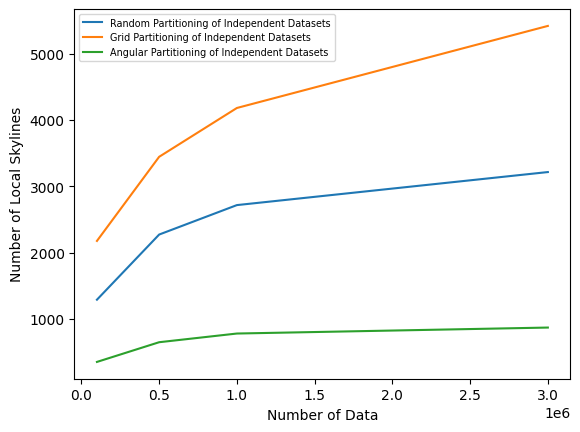

In [13]:
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
numDatas = [1*10**5, 5*10**5, 1*10**6, 3*10**6]
local1 = []
local2 = []
local3 = []
def parallel_sfs_(data, weights, numberOfSlices = -1):
    start1 = time.time()
    if numberOfSlices == -1 :
        numberOfSlices = min(max(8,  ceil((sys.getsizeof(data)/1024/1000) * 0.4 ) ), 24)
    initialValues = spark.sparkContext.parallelize(data, numberOfSlices).mapPartitions(lambda x: find_skyline_sfs(x, weights),
                                                                       preservesPartitioning = True).collect()
    end = time.time() - start1
    print("Length of the local skylines after parallel section is : " + str(len(initialValues)) + ", time taken: " + str(end))

    return initialValues


#Angular partitioning
def parallel_angled_partitioning_sfs_(dataArray, weights, numSlices = 5):

    dimensions = len(dataArray[0])

    #numberOfSlices = min(max(8,  ceil((sys.getsizeof(dataArray)/1024/1000) * 0.4 ) ), 24)
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    initialResult = spark.sparkContext.parallelize(dataArray) \
                    .map(lambda x : ( get_angular_partitionIndex(x, dimensions, numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, weights), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('AP: Length of skyline after parallel phase is :' + str(len(initialResult))+ ", time taken: "+ str(end))
    return initialResult




#grid partitioning
def parallel_grid_partitioning_sfs_(dataArray, weights, numSlices = 2):
    dimensions = len(dataArray[0])

    start = time.time()
    initialResults = spark.sparkContext.parallelize(dataArray) \
                    .map(lambda x : ( get_grid_partition_index(x, numSlices), x ) )  \
                    .partitionBy(numSlices**dimensions) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, weights), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('GP: Length of skyline after parallel phase is :' + str(len(initialResults)) + ",time taken: "+ str(end))
    return initialResults

for numData in numDatas:
    dataConfig = DataGenConfig(numberOfData = numData, typeOfCorrelation=DataGenEnum.independent, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()
    local1.append(len(parallel_sfs_(datapoints, centroids, 8)))
    local2.append(len(parallel_angled_partitioning_sfs_(datapoints, centroids, 2)))
    local3.append(len(parallel_grid_partitioning_sfs_(datapoints, centroids, 2)))

plt.plot(numDatas, local1, label='Random Partitioning of Independent Datasets')
plt.plot(numDatas, local3, label='Grid Partitioning of Independent Datasets')
plt.plot(numDatas, local2, label='Angular Partitioning of Independent Datasets')
plt.xlabel("Number of Data")
plt.ylabel("Number of Local Skylines")

plt.legend(fontsize='x-small')



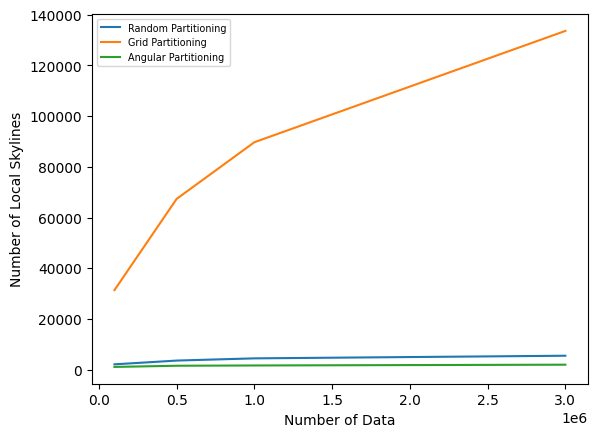

In [21]:
plt.plot(numDatas, local1, label='Random Partitioning')
plt.plot(numDatas, local3, label='Grid Partitioning')
plt.plot(numDatas, local2, label='Angular Partitioning')
plt.xlabel("Number of Data")
plt.ylabel("Number of Local Skylines")

plt.legend(fontsize='x-small')

Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
3000000
Slices for representative skyline 100
Time taken for sorting: 2.2871530055999756


23/03/27 15:15:49 WARN TaskSetManager: Stage 0 contains a task of very large size (29304 KiB). The maximum recommended task size is 1000 KiB.


Length of representatives: 44, time taken to find: 9.12058687210083
23/03/27 15:15:55 WARN TaskSetManager: Stage 1 contains a task of very large size (1165 KiB). The maximum recommended task size is 1000 KiB.


Length of the parallel section skyline: 37893, time taken to find it: 9.073082447052002


Length of the skyline: 30170, Time taken to find: 24.250252962112427
Total time taken with representatives: 44.7318172454834
44.741429805755615
Slices for representative skyline 100
Time taken for sorting: 3.0130698680877686
23/03/27 15:16:33 WARN TaskSetManager: Stage 3 contains a task of very large size (29304 KiB). The maximum recommended task size is 1000 KiB.


Length of representatives: 38, time taken to find: 5.891317367553711
23/03/27 15:16:39 WARN TaskSetManager: Stage 4 contains a task of very large size (1165 KiB). The maximum recommended task size is 1000 KiB.


Length of the parallel section skyline: 27497, time taken to find it: 30.87715196609497


Length of nd: 20566, Time taken to find: 119.10855460166931
Total time taken with representatives: 158.89898133277893
158.9020140171051


Length of po after parallel phase: 4452, Time taken to find: 44.008902072906494


Length of po: 175, Time taken to find: 82.93531680107117
82.93785810470581
5000000
Slices for representative skyline 100
Time taken for sorting: 3.940640687942505
23/03/27 15:21:08 WARN TaskSetManager: Stage 8 contains a task of very large size (48837 KiB). The maximum recommended task size is 1000 KiB.


Length of representatives: 45, time taken to find: 8.338746070861816
23/03/27 15:21:16 WARN TaskSetManager: Stage 9 contains a task of very large size (1925 KiB). The maximum recommended task size is 1000 KiB.


Length of the parallel section skyline: 48207, time taken to find it: 13.348090648651123


Length of the skyline: 39240, Time taken to find: 34.93064856529236
Total time taken with representatives: 60.5590443611145
60.5724675655365
Slices for representative skyline 100
Time taken for sorting: 3.905125856399536
23/03/27 15:22:09 WARN TaskSetManager: Stage 11 contains a task of very large size (48837 KiB). The maximum recommended task size is 1000 KiB.


Length of representatives: 39, time taken to find: 8.991341829299927
23/03/27 15:22:18 WARN TaskSetManager: Stage 12 contains a task of very large size (1925 KiB). The maximum recommended task size is 1000 KiB.


Length of the parallel section skyline: 34905, time taken to find it: 49.690190076828


Length of nd: 26807, Time taken to find: 175.1571934223175
Total time taken with representatives: 237.75202202796936
237.77172231674194


Length of po after parallel phase: 4855, Time taken to find: 60.731220960617065


Length of po: 202, Time taken to find: 103.1128580570221
103.11422300338745


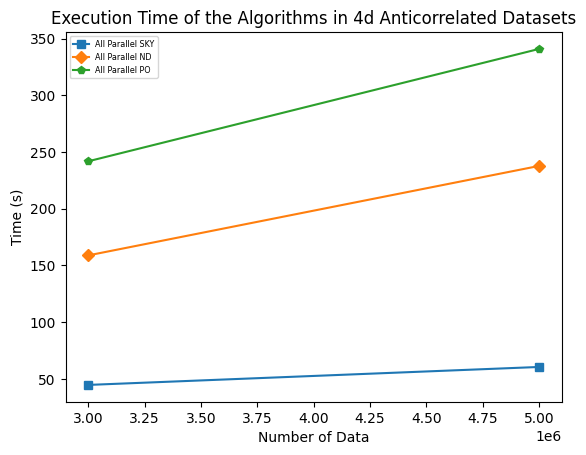

In [24]:
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
#dts = ["dataset1.csv", "dataset2.csv", "dataset3.csv", "dataset4.csv", "dataset5.csv"]
numD = [3*10**6, 5*10**6]
time_par_sky = []
time_par_nd = []
time_par_po = []
constraints = [[-1, 1, 0, 0]]
k_ = [0]
p = 1
import random
for numData in numD:
    
    dataConfig = DataGenConfig(numberOfData = numData, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()
    print(len(datapoints))


    start = time.time()
    AllParallel_sfs(datapoints, centroids, numberOfSlices=100)
    end = time.time() -start
    print(end)
    time_par_sky.append(end)


    start = time.time()
    nd = parallel3P_sve1f(datapoints, vertices, p, 100)
    end_nd = time.time() -start
    print(end_nd)
    time_par_nd.append(end_nd)

    start = time.time()
    parallel3P_pond_primal(nd, constraints, k_, 100)
    end_po = time.time() -start
    print(end_po)
    time_par_po.append(end_nd+end_po)

#     start = time.time()
#     data = representative_smallest(datapoints, centroids, 500, onlyFilter = False)
#     sky = find_skyline_sfs(data, centroids)
#     print(len(sky))
#     end = time.time() -start
#     print(end)
#     time_angular_repr.append(end)

#    start = time.time()
#    AllParallel_sfs(datapoints, centroids)
#   end = time.time()-start
#    print(end)
#    time_all_parallel1.append(end)
    
#     start = time.time()
#     AllParallel_sfs2(datapoints, centroids)
#     end = time.time()-start
#     print(end)
#     time_all_parallel1.append(end)
    


#plt.plot(numD, time_centr, label='Centralized SFS', marker = '*')
#plt.plot(numD, time_random, label='Random Partitioning PO', marker = 'o')
#plt.plot(numD, time_grid, label='Grid Partitioning PO', marker = '+')
plt.plot(numD, time_par_sky, label='All Parallel SKY', marker = 's')
plt.plot(numD, time_par_nd, label='All Parallel ND ', marker = 'D')
plt.plot(numD, time_par_po, label='All Parallel PO', marker = 'p')
#plt.plot(numD, time_repr, label='Representative Filtering (Dominance Region) + Angular Partitioning SFS',marker = 'h')
#plt.plot(numD, time_all_parallel2, label='All Parallel SFS + Representative Filtering (Dominance Region v1)', marker = 'v')
#plt.plot(numD, time_all_parallel1, label='All Parallel SFS + Representative Filtering (Dominance Region)', marker = '<')


plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the Algorithms in 4d Anticorrelated Datasets")

plt.legend(fontsize='xx-small')

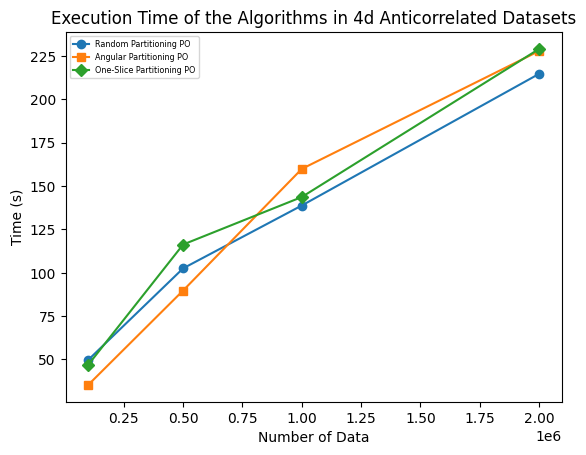

In [41]:
numD = [1*10**5, 5*10**5, 1*10**6, 2*10**6]

#plt.plot(numD, time_centr, label='Centralized SFS', marker = '*')
plt.plot(numD, time_random, label='Random Partitioning PO', marker = 'o')
#plt.plot(numD, time_grid, label='Grid Partitioning PO', marker = '+')
plt.plot(numD, time_angular, label='Angular Partitioning PO', marker = 's')
plt.plot(numD, time_sliced, label='One-Slice Partitioning PO', marker = 'D')
#plt.plot(numD, time_angular_repr, label='Representative Filtering (Sorted method) + SFS', marker = 'p')
#plt.plot(numD, time_repr, label='Representative Filtering (Dominance Region) + Angular Partitioning SFS',marker = 'h')
#plt.plot(numD, time_all_parallel2, label='All Parallel SFS + Representative Filtering (Dominance Region v1)', marker = 'v')
#plt.plot(numD, time_all_parallel1, label='All Parallel SFS + Representative Filtering (Dominance Region)', marker = '<')


plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the Algorithms in 4d Anticorrelated Datasets")

plt.legend(fontsize='xx-small')


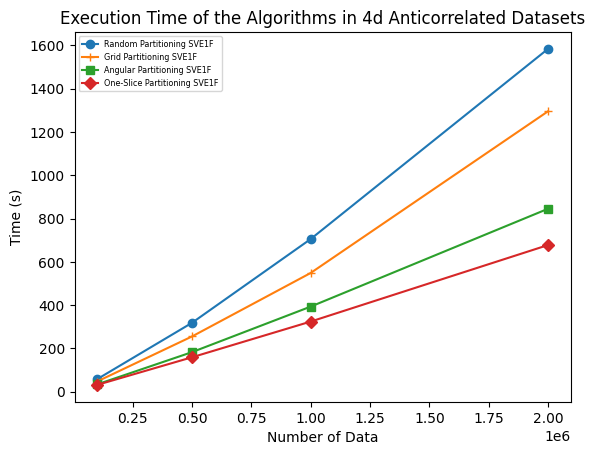

In [22]:
time_random = [57.85, 318.45, 705.42, 1583.99]
time_angular = [33.85, 182.93, 393.28, 845.31]
time_sliced = [31.44, 159.22, 324.18, 677.65]
numD = [1*10**5, 5*10**5, 1*10**6, 2*10**6]
#plt.plot(numD, time_centr, label='Centralized SFS', marker = '*')
plt.plot(numD, time_random, label='Random Partitioning PO', marker = 'o')
#plt.plot(numD, time_grid, label='Grid Partitioning SVE1F', marker = '+')
plt.plot(numD, time_angular, label='Angular Partitioning PO', marker = 's')
plt.plot(numD, time_sliced, label='One-Slice Partitioning PO', marker = 'D')
#plt.plot(numD, time_angular_repr, label='Representative Filtering (Sorted method) + SFS', marker = 'p')
#plt.plot(numD, time_repr, label='Representative Filtering (Dominance Region) + Angular Partitioning SFS',marker = 'h')
#plt.plot(numD, time_all_parallel2, label='All Parallel SFS + Representative Filtering (Dominance Region v1)', marker = 'v')
#plt.plot(numD, time_all_parallel1, label='All Parallel SFS + Representative Filtering (Dominance Region)', marker = '<')


plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the Algorithms in 4d Anticorrelated Datasets")

plt.legend(fontsize='xx-small')

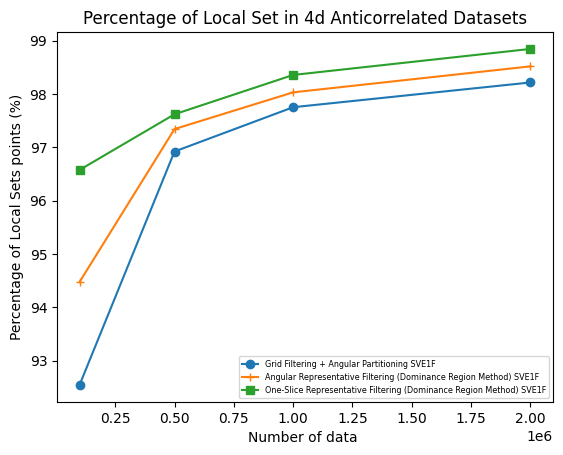

In [31]:
ls_random =[7453, 15390, 22478, 35679]
#ls_grid = [9324, 18091, 25551, 35946]
ls_angular = [5523, 13286, 19690, 29640]
ls_sliced = [3423, 11901, 16430, 23104]
numDatas = [1*10**5, 5*10**5, 1*10**6, 2*10**6]
filter_rand = []
filter_grid = []
filter_ang = []
filter_slice = []
for i in range(len(numDatas)):
    filter_rand.append(100-ls_random[i]*100/numD[i])
    #filter_grid.append(100-ls_grid[i]*100/numD[i])
    filter_ang.append(100-ls_angular[i]*100/numD[i])
    filter_slice.append(100-ls_sliced[i]*100/numD[i])
#plt.plot(numD, time_centr, label='Centralized SFS', marker = '*')
plt.plot(numDatas, filter_rand, label='Grid Filtering + Angular Partitioning SVE1F', marker = 'o')
plt.plot(numDatas, filter_ang, label='Angular Representative Filtering (Dominance Region Method) SVE1F', marker = '+')
plt.plot(numDatas, filter_slice, label='One-Slice Representative Filtering (Dominance Region Method) SVE1F', marker = 's')


plt.xlabel("Number of data ")
plt.ylabel("Percentage of Local Sets points (%)")
plt.title("Percentage of Local Set in 4d Anticorrelated Datasets")

plt.legend(fontsize='xx-small')

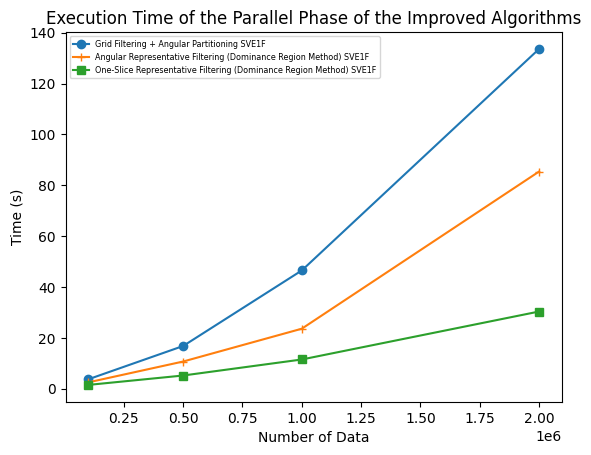

In [9]:
time_grid_ang = [3.7, 16.8, 46.5, 133.6]
time_repr_ang = [2.5,10.7, 23.6, 85.4]
time_repr_slice = [1.5, 5.2, 11.5, 30.36]
#time_all_par = [2.49, 7.04, 13.89, 25.15, 38.18]
numDatas = [1*10**5, 5*10**5, 1*10**6, 2*10**6]
#plt.plot(numD, time_centr, label='Centralized SFS', marker = '*')
plt.plot(numDatas, time_grid_ang, label='Grid Filtering + Angular Partitioning SVE1F', marker = 'o')
plt.plot(numDatas, time_repr_ang, label='Angular Representative Filtering (Dominance Region Method) SVE1F', marker = '+')
plt.plot(numDatas, time_repr_slice, label='One-Slice Representative Filtering (Dominance Region Method) SVE1F', marker = 's')
#plt.plot(numDatas, time_all_par, label='All Parallel SFS', marker = 'D')
#plt.plot(numD, time_angular_repr, label='Representative Filtering (Sorted method) + SFS', marker = 'p')
#plt.plot(numD, time_repr, label='Representative Filtering (Dominance Region) + Angular Partitioning SFS',marker = 'h')
#plt.plot(numD, time_all_parallel2, label='All Parallel SFS + Representative Filtering (Dominance Region v1)', marker = 'v')
#plt.plot(numD, time_all_parallel1, label='All Parallel SFS + Representative Filtering (Dominance Region)', marker = '<')


plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the Parallel Phase of the Improved Algorithms")

plt.legend(fontsize='xx-small')

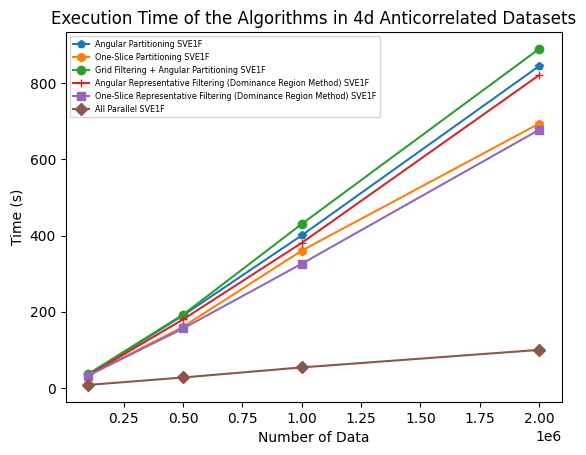

In [25]:
time_grid_ang = [36.4, 192.4, 430.6, 890.4]
time_angular =[33.5, 190.5, 400.7, 845.31]
time_sliced = [32.5, 160.5, 360.5, 694.11]
time_repr_ang = [32.79, 179.8, 380.97, 821.45]
time_repr_slice = [32.15, 155.92, 326.04, 677.86]
time_all_par = [7.62, 27.18, 53.66, 99.66]
numDatas = [1*10**5,5*10**5,1*10**6,2*10**6]
plt.plot(numDatas, time_angular, label='Angular Partitioning SVE1F', marker = 'p')
plt.plot(numDatas, time_sliced, label='One-Slice Partitioning SVE1F',marker = 'h')
plt.plot(numDatas, time_grid_ang, label='Grid Filtering + Angular Partitioning SVE1F', marker = 'o')
plt.plot(numDatas, time_repr_ang, label='Angular Representative Filtering (Dominance Region Method) SVE1F', marker = '+')
plt.plot(numDatas, time_repr_slice, label='One-Slice Representative Filtering (Dominance Region Method) SVE1F', marker = 's')
plt.plot(numDatas, time_all_par, label='All Parallel SVE1F', marker = 'D')

#plt.plot(numD, time_all_parallel2, label='All Parallel SFS + Representative Filtering (Dominance Region v1)', marker = 'v')
#plt.plot(numD, time_all_parallel1, label='All Parallel SFS + Representative Filtering (Dominance Region)', marker = '<')


plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the Algorithms in 4d Anticorrelated Datasets")

plt.legend(fontsize='xx-small')


In [24]:
#dts = ["dataset1.csv", "dataset2.csv", "dataset3.csv", "dataset4.csv", "dataset5.csv"]
numDatas = [1*10**5, 5*10**5, 1*10**6, 2*10**6, 3*10**6]
time_grid_angular = []
time_rep_ang = []
time_rep_slice = []
time_all_p = []

p = 1
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
for numData in numDatas:
    dataConfig = DataGenConfig(numberOfData = numData, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()
    print('--------------------------')

    start = time.time()
    nd = parallel_representative_filtering_nd_angular(datapoints, vertices,p, onlyFilter = False)
    sky = sve1f(nd, vertices, p)
    end = time.time() -start
    print(end)
    time_rep_ang.append(end)

    start = time.time()
    nd = parallel_3P_sve1f(datapoints, vertices, p, slicesForSorting=100)
    sky = sve1f(nd, vertices, p)
    print(len(sky))
    end = time.time() -start
    print(end)
    time_rep_slice.append(end)

    start = time.time()
    parallel3P_sve1f(datapoints, vertices, p, 100)
    end = time.time() -start
    print(end)
    time_all_p.append(end)



#plt.plot(numDatas, time_centr, label='Centralized SFS', marker = '*')
plt.plot(numDatas, time_grid_angular, label='Grid Filtering + Angular Partitioning SVE1F', marker = 'o')
plt.plot(numDatas, time_rep_ang, label='Angular Representative Filtering (Dominance Region Method) SVE1F', marker = '+')
plt.plot(numDatas, time_rep_slice, label='One-Slice Representative Filtering (Dominance Region Method) SVE1F', marker = 's')
plt.plot(numDatas, time_all_p, label='All Parallel SVE1F', marker = 'D')
#plt.plot(numD, time_angular_repr, label='Representative Filtering (Sorted method) + SFS', marker = 'p')
#plt.plot(numDatas, time_repr, label='Representative Filtering ND (Dominance Region) + Angular Partitioning SVE1F',marker = 'h')
#plt.plot(numD, time_all_parallel2, label='All Parallel SFS + Representative Filtering (Dominance Region v1)', marker = 'v')
#plt.plot(numDatas, time_all_parallel1, label='All Parallel SVE1F + Representative Filtering ND (Dominance Region)', marker = '<')


plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the Improved Algorithms in 4d Anticorrelated Datasets")

plt.legend(fontsize='xx-small')

Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
--------------------------


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
100000
[0.375, 0.125, 0.25, 0.25]
Number of points in the skyline 3976
Time taken 29.07909345626831
1378
34.76021146774292
1378
23.220711708068848
1378
19.818715572357178
500000
[0.375, 0.125, 0.25, 0.25]
Number of points in the skyline 6697
Time taken 227.23771929740906
2183
242.99738216400146
2183
146.39769172668457
2183
117.99274396896362
1000000
[0.375, 0.125, 0.25, 0.25]
Number of points in the skyline 7901
Time taken 549.4121382236481
2773
574.8216035366058
2773
358.946861743927
2773
304.3672413825989


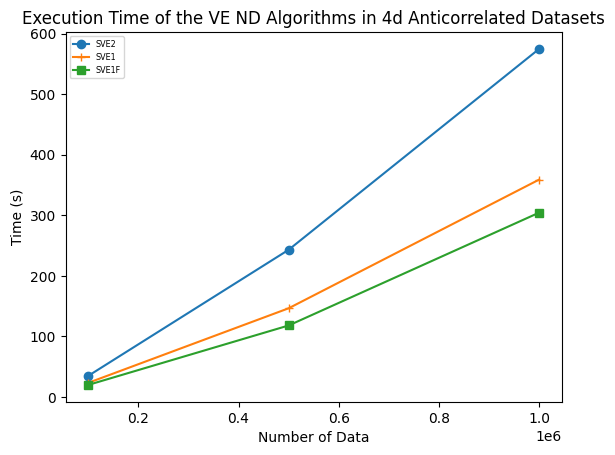

In [16]:
p = 1
model = LpProblem(sense=LpMinimize)
# Initialize the decision variables
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)


time_sve2 = []
time_sve1 = []
time_sve1f = []
dts = ["dataset1.csv", "dataset2.csv", "dataset3.csv"]
numDatas = []
for dt in dts:
    dataArray = pd.read_csv(os.getcwd() + "/datasets/" + dt, delimiter= ' ', header=None)
    datapoints = (dataArray.values).tolist()
    numDatas.append(len(datapoints))
    print(len(datapoints))

    start = time.time()
    sve2_ = sve2(datapoints, vertices, p)
    print(len(sve2_))
    end = time.time() -start
    time_sve2.append(end)
    print(end)

    start = time.time()
    sve1_ = sve1(datapoints, vertices, p)
    print(len(sve1_))
    end = time.time() -start
    time_sve1.append(end)
    print(end)

    start = time.time()
    sve1f_ = sve1f(datapoints, vertices, p)
    print(len(sve1f_))
    end = time.time() -start
    time_sve1f.append(end)
    print(end)

plt.plot(numDatas, time_sve2, label='SVE2', marker = 'o')
plt.plot(numDatas, time_sve1, label='SVE1', marker = '+')
plt.plot(numDatas, time_sve1f, label='SVE1F', marker = 's')

plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the VE ND Algorithms in 4d Anticorrelated Datasets")
plt.legend(fontsize='xx-small')

Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
--------------------------
Length of nd after parallel section: 797, time taken: 0.47907376289367676
Length of nd is : 257, time taken: 0.2444002628326416
Total time nd: 0.7234740257263184
Length of nd after parallel section: 797, time taken: 0.34099888801574707
Length of nd is : 257, time taken: 0.2506890296936035
Total time nd: 0.5916879177093506
25
14.397490978240967
25
13.300787687301636
--------------------------
Length of nd after parallel section: 4062, time taken: 0.4985079765319824
Length of nd is : 963, time taken: 3.347916603088379
Total time nd: 3.8464245796203613
Length of nd after parallel section: 4062, time taken: 0.4632229804992676
Length of nd is : 963, time taken: 3.248610496520996
Total time nd: 3.7118334770202637
69
78.63957214355469
69
70.03828811645508
--------------------------


Length of nd after parallel section: 15621, time taken: 3.4862101078033447
Length of nd is : 3420, time taken: 43.73754096031189
Total time nd: 47.223751068115234


Length of nd after parallel section: 15621, time taken: 2.58671236038208
Length of nd is : 3420, time taken: 43.78936576843262
Total time nd: 46.3760781288147
95
358.8224115371704
95
319.7218141555786


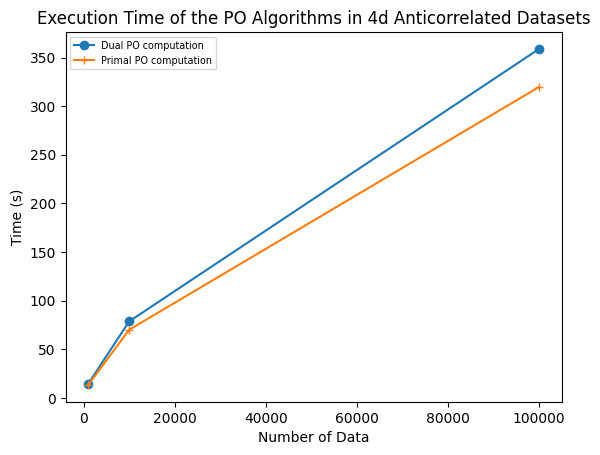

In [51]:
numDatas = [1*10**3, 1*10**4, 1*10**5]
time_primal = []
time_dual = []
constraints = [[-1, 1, 0, 0]]
k_ = [0]
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
for numData in numDatas:
    dataConfig = DataGenConfig(numberOfData = numData, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()
    print('--------------------------')
    nd1 = parallelSVE1F(datapoints, vertices, 1)
    nd2 = parallelSVE1F(datapoints, vertices, 1)

    start = time.time()
    sky = POND(nd1, vertices, 1)
    print(len(sky))
    end = time.time() -start
    time_dual.append(end)
    print(end)

    start = time.time()

    sky = po_primal_pulp(nd2, constraints, k_)
    print(len(sky))
    end = time.time() -start
    time_primal.append(end)
    print(end)
    start = time.time()






plt.plot(numDatas, time_dual, label='Dual PO computation', marker = 'o')
plt.plot(numDatas, time_primal, label='Primal PO computation', marker = '+')

plt.xlabel("Number of Data")
plt.ylabel("Time (s)")
plt.title("Execution Time of the PO Algorithms in 4d Anticorrelated Datasets")
plt.legend(fontsize='x-small')

In [26]:
dataConfig = DataGenConfig(numberOfData = 10000, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
dataArray = spark.sparkContext.parallelize([0,1,2],100).mapPartitions(lambda x: dataGenerator(x,dataConfig)).collect()
print(len(dataArray))
print(dataArray[0:10])

1000000
[[0.7388848131435155, 0.3086224084484565, 0.3613460679675193, 0.33220832487444785], [0.7387193314055003, 0.3267820446479053, 0.17835913734980757, 0.33745360278410114], [0.05980987203768351, 0.9940088824462658, 0.6965425536854323, 0.5033548045384826], [0.9683611558364225, 0.039071649993131785, 0.037869649434856906, 0.04259843362527475], [0.7660673542383235, 0.2260158604949544, 0.22107155719911628, 0.3021765515772753], [0.5426093153796719, 0.37504742357369647, 0.2320814773898921, 0.47397505591479383], [0.9410423472293257, 0.04937984501860393, 0.048583466776317405, 0.06809243534937433], [0.983952079831477, 0.01996469723519205, 0.015282112100460737, 0.01578911903523788], [0.12056097575572033, 0.8046111527605938, 0.647949849871116, 1.1824252357752292], [0.46693686956709646, 0.2678295740235972, 0.4607254678711982, 0.7777673632476252]]


In [25]:
vertices = computeVertices(E,f,G,h)
centroids = compute_centroid(vertices)
print('--------------------------')
dataConfig = DataGenConfig(numberOfData = 1*10**5, typeOfCorrelation=DataGenEnum.anticorrelated, numberOfDimensions = 4,dataRange = [0,1],  spreadPercentage = 100)
dataArray = dataGenerator(dataConfig)
datapoints = normalize_data(dataArray).tolist()


parallel_sfs(datapoints, centroids)
sliced_partitioning_sfs(datapoints, centroids)

Vertices: [[0.5, 0.5, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
--------------------------


comparisons:314743                                                (0 + 30) / 30]
comparisons:329200
comparisons:359594
comparisons:356615
comparisons:418134
comparisons:331443
comparisons:377243
comparisons:524369
comparisons:322215
comparisons:344782
comparisons:356086
comparisons:331488
comparisons:332748
comparisons:334239
comparisons:349202
comparisons:489705
comparisons:343098
comparisons:395704
comparisons:355985========================>                      (18 + 12) / 30]
comparisons:355519
comparisons:491296
comparisons:516961
comparisons:333948
comparisons:431589
comparisons:464830
comparisons:380127
comparisons:310052
comparisons:377418
comparisons:499025
comparisons:502095==============================================> (29 + 1) / 30]


Length of the local skylines after parallel section is : 20433, time taken: 6.301923036575317
comparisons:19497670
Length of the skyline is : 4789, total time taken: 13.39561915397644
Time taken for sorting: 0.048925161361694336


comparisons:44305
comparisons:21281
comparisons:34921
comparisons:25646
comparisons:42924
comparisons:49324
comparisons:23717
comparisons:24078
comparisons:29304comparisons:23778

comparisons:46922
comparisons:21780
comparisons:31774comparisons:21140

comparisons:29890
comparisons:27233
comparisons:26475
comparisons:59361
comparisons:23920
comparisons:59758
comparisons:20548
comparisons:54812
comparisons:21114
comparisons:111468
comparisons:47419
comparisons:52291
comparisons:85196
comparisons:43126
comparisons:34663
comparisons:383087


Length of the local skylines after parallel section is : 6158, time taken: 0.8167986869812012
comparisons:11984812
Length of the skyline is : 4789, total time taken: 4.866730451583862
